# Portfolio Optimization

- Portfolio Optimization

After we get the ranking, we choose the top 25% percentile stocks for each quarter as our stock pool to build our portfolio. The way we build the optimal portfolio is to set the objective as getting the maximum Sharpe Ratio. Weights of each stock are the decision variables. Constraints are the sum of the weights is equal to 1 and each weight should not be smaller than 0. Then we can get an optimal solution for the optimal weights for each stock. Then we build the portfolio according to the weights.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime

## User idefiend functions to calculate the optimal combination of stocks
- By maximizing Sharpe Ratio. It is the average return earned in excess of the risk-free rate per unit of volatility or total risk.

In [ ]:

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate,noa):    # cov_matrix = covariance
    num_assets = len(mean_returns)                                     # number of stock
                                                                       # can confirm the stock #s by the mean return of each stock
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
    # constraints 'np.sum(x)=1' --> sum of weights is 1
    # therefore, the formula to import constraints 'np.sum(x)=1 sum of weights -1' is eual to '0'
    # 'eq' = equal
    # x = weight of each stock
    
    
    bound = (0.0,1.0)                                                  # each variable's range is [0,1]
    bounds = tuple(bound for asset in range(num_assets))               # set the bound to each variable
    result = sco.minimize(neg_sharpe_ratio, noa*[1./noa,], args=args, method='SLSQP', 
                          bounds=bounds, constraints=constraints)
    # sco.minimize() --> minimizing objective functions
    # result returns the min(negative sharpe ratio)
    # neg_sharpe_ratio is objective function, noa*[1./noa,] is start points, set each stock equal weight
    # method 'Sequential Least Squares Programming'
    
    return result



In [1]:

def portfolio_monthly_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252       # total returns for each stock in 2015, 252 is the number of days in 2015
    
    #std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # std is the Expected portfolio standard deviation = SQRT (WT * (Covariance Matrix) * W)
    # https://blog.quantinsti.com/calculating-covariance-matrix-portfolio-variance/
    # do bot understand why multiply np.sqrt(252)
   
    return std, returns
    # portfolio_monthly_performance[0] is standard deviation of portfolio

    
    
# they do not use the 'random_portfolios' function
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate,noa):
    results = np.zeros((3,num_portfolios)) # make a shape of 3*num_portfolios matrix with 0
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(noa) # noa is 30, get 30 random number ~ N(0,1)
        weights /= np.sum(weights)      # weights = weights/np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_monthly_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev # portfolio standard deviation
        results[1,i] = portfolio_return # portfolio return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev # portfolio sharpe ratio
  
     return results, weights_record



In [ ]:

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_monthly_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var
# p_var is the standard deviation of of best portfolio, p_ret is the best portfolio return


def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate,noa):
    num_assets = len(mean_returns) # number of stock
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # constraints np.sum(x)=1 sum of weights is 1
    bound = (0.0,1.0) # each variable's range is [0,1]
    bounds = tuple(bound for asset in range(num_assets)) # set the bound to each variable
    result = sco.minimize(neg_sharpe_ratio, noa*[1./noa,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    # result returns the min(negative sharpe ratio)
    # neg_sharpe_ratio is objective function, noa*[1./noa,] is start points, set each stock equal weight
    # method 'Sequential Least Squares Programming'

    return result



In [2]:

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_monthly_performance(weights, mean_returns, cov_matrix)[0]
    # portfolio_monthly_performance[0] is standard deviation of portfolio

    
def min_variance(mean_returns, cov_matrix,noa):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(noa))

    result = sco.minimize(portfolio_volatility, noa*[1./noa,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    # to minimize the standard deviation of portfolio

    return result



In [ ]:

def portfolio_return(weights):
        return portfolio_monthly_performance(weights, mean_returns, cov_matrix)[1]


# they do not use this function
def efficient_return(mean_returns, cov_matrix, target,noa):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target}, 
                   # let portfolio's return is equal to target
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, noa*[1./noa,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    # to minimize the standard deviation of portfolio
    return result


# they do not use this function
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))

    return efficients



# backtesting

Backtesting means using only historical data to get the portfolio and test the performance of that portfolio in the future. For example, if we want to know the portfolio’s performance in 2022 Quarter 1. We will use the optimal portfolio for 2022 Quarter 1, which is created using the data before 2022 Quarter 1. Then we invest the money we get after selling the portfolio in 2021 Quarter 4, and run the real return rate for the new portfolio in 2022 Quarter 1. We can calculate the return at this period and compare it with the index return.

We try to build portfolios based on the top 5%, 10%, 15%, 20%, 25%, 30% percentile of the stocks and find that 25% percentile not only performs good in return rate but also does not contain too many stocks in the stock pool. The best method for building a portfolio based on 25% percentile is linear regression. The daily, monthly, quarterly, yearly returns of the model and the maket index S&P 500 Health is following.


# targets_ols = the ranking you get, different methods will have different targets

# dff is the dataset with percent_change, date, actual close price, and ticker name for all the stock.

In [ ]:
dff = pd.read_csv('backtesting_jul20 (4).csv')
dff = dff[['date','Quarter','Ticker','pct_chg']].dropna()
dff.head()

,date,Quarter,Ticker,pct_chg
183,2012-01-04,2012Q1,DGX,-0.002422
184,2012-01-04,2012Q1,THC,-0.054435
185,2012-01-04,2012Q1,PRPH,-0.016393
186,2012-01-04,2012Q1,PDEX,0.000000
187,2012-01-04,2012Q1,QDEL,-0.015375


# number of the date is 2578

In [ ]:
len(dff['date'].unique())

2578

In [ ]:
dff.dtypes

date        object
Quarter     object
Ticker      object
pct_chg    float64
dtype: object

In [ ]:
dff['date'] = pd.to_datetime(dff['date'])
dff.dtypes

date       datetime64[ns]
Quarter            object
Ticker             object
pct_chg           float64
dtype: object

# read target stock for each quarter in 4 methods: xgb_all, ebm_all, ols, equal

In [ ]:
xgb_all = pd.read_csv('xgb_all_July27_25%.csv')
xgb_all

,Quarter,Ticker
0,2012Q2,['RDNT' 'CYH' 'ADUS' 'HCA' 'NOTV' 'AMEH' 'AMED...
1,2012Q3,['RDNT' 'CYH' 'ADUS' 'NOTV' 'HCA' 'AMED' 'PDEX...
2,2012Q4,['RDNT' 'ADUS' 'HCA' 'CYH' 'AMED' 'NOTV' 'PDEX...
3,2013Q1,['RDNT' 'HCA' 'CYH' 'AMED' 'ADUS' 'ANTM' 'PDEX...
4,2013Q2,['RDNT' 'HCA' 'AMED' 'ANTM' 'CYH' 'PDEX' 'ENSG...
5,2013Q3,['HCA' 'AMED' 'ANTM' 'PDEX' 'CYH' 'ENSG' 'INFU...
6,2013Q4,['HCA' 'CYH' 'INFU' 'ANTM' 'PDEX' 'NOTV' 'AMED...
7,2014Q1,['HCA' 'CYH' 'ANTM' 'AMED' 'PDEX' 'RDNT' 'ENSG...
8,2014Q2,['HCA' 'CYH' 'ANTM' 'PDEX' 'AMED' 'RDNT' 'ENSG...
9,2014Q3,['HCA' 'CYH' 'ANTM' 'RDNT' 'AMED' 'PDEX' 'LHCG...


# input the target stocks name into variables, like put xgb_all stocks for 12Q2 into targets_xgb_all_12Q2

In [ ]:
xgb_all['Quarter']

0     2012Q2
1     2012Q3
2     2012Q4
3     2013Q1
4     2013Q2
5     2013Q3
6     2013Q4
7     2014Q1
8     2014Q2
9     2014Q3
10    2014Q4
11    2015Q1
12    2015Q2
13    2015Q3
14    2015Q4
15    2016Q1
16    2016Q2
17    2016Q3
18    2016Q4
19    2017Q1
20    2017Q2
21    2017Q3
22    2017Q4
23    2018Q1
24    2018Q2
25    2018Q3
26    2018Q4
27    2019Q1
28    2019Q2
29    2019Q3
30    2019Q4
31    2020Q1
32    2020Q2
33    2020Q3
34    2020Q4
35    2021Q1
36    2021Q2
37    2021Q3
38    2021Q4
39    2022Q1
Name: Quarter, dtype: object

In [ ]:
xgb_all = xgb_all.replace('\[','',regex=True).replace('\]','',regex=True).replace('\\n','',regex=True).replace('\'','',regex=True)
xgb_all['Ticker'] = xgb_all['Ticker'].str.split()
names = locals()
for i in xgb_all['Quarter']:
    names['targets_xgb_all_' + str(i[2:]) ] = xgb_all[xgb_all['Quarter']==i]['Ticker'].values[0]

In [ ]:
targets_xgb_all_12Q2

['RDNT',
 'CYH',
 'ADUS',
 'HCA',
 'NOTV',
 'AMEH',
 'AMED',
 'ENSG',
 'PDEX',
 'TVTY',
 'ANTM',
 'SEM',
 'LNDC',
 'THC',
 'NHC',
 'LHCG',
 'INFU',
 'PRPH',
 'BSX',
 'ATEC',
 'CCEL',
 'HSKA',
 'MACK',
 'CVS',
 'ITGR',
 'AMN',
 'CI',
 'AORT',
 'SRGA',
 'UHS',
 'CDXS',
 'MOH',
 'SNDA',
 'ANGO',
 'HUM',
 'CNMD',
 'OMI',
 'BLFS',
 'OPCH',
 'NUVA',
 'HNGR',
 'CAH',
 'NTUS']

In [ ]:
ebm_all = pd.read_csv('ebm_all_July27_25%.csv')
ebm_all.head()

,Quarter,Ticker
0,2012Q2,['INVA' 'ANIK' 'UTHR' 'EW' 'CI' 'MYGN' 'PMD' '...
1,2012Q3,['UTHR' 'ANIK' 'CI' 'MYGN' 'UFPT' 'REGN' 'AMGN...
2,2012Q4,['CI' 'UTHR' 'MYGN' 'REGN' 'UFPT' 'CUTR' 'EBS'...
3,2013Q1,['UTHR' 'EBS' 'NBIX' 'UFPT' 'MYGN' 'ZBH' 'ANIK...
4,2013Q2,['UTHR' 'MYGN' 'EBS' 'ANIK' 'CUTR' 'GMED' 'UFP...


In [ ]:
ebm_all = ebm_all.replace('\[','',regex=True).replace('\]','',regex=True).replace('\\n','',regex=True).replace('\'','',regex=True)
ebm_all['Ticker'] = ebm_all['Ticker'].str.split()
for i in ebm_all['Quarter']:
    names['targets_ebm_all_' + str(i[2:]) ] = ebm_all[ebm_all['Quarter']==i]['Ticker'].values[0]
    #print(names['targets_ebm_all_' + str(i[2:])])

In [ ]:
targets_ebm_all_12Q2

['INVA',
 'ANIK',
 'UTHR',
 'EW',
 'CI',
 'MYGN',
 'PMD',
 'MD',
 'UFPT',
 'ICUI',
 'SRDX',
 'HSKA',
 'ZBH',
 'ELMD',
 'RMD',
 'NBIX',
 'TECH',
 'HCA',
 'INCY',
 'ATEC',
 'ATRI',
 'AMGN',
 'EBS',
 'HSIC',
 'CYH',
 'REGN',
 'UTMD',
 'JNJ',
 'SYK',
 'ITGR',
 'MDT',
 'SAVA',
 'CUTR',
 'LHCG',
 'ABT',
 'MRK',
 'VERU',
 'VIVO',
 'AMEH',
 'ENSG',
 'USPH',
 'HALO',
 'LUNA']

In [ ]:
ols = pd.read_csv('ols_July27_25%.csv')
ols.head()

,Quarter,Ticker
0,2012Q2,['CYTK' 'VNDA' 'ICUI' 'NUS' 'ELMD' 'FONR' 'VCE...
1,2012Q3,['INVA' 'CCXI' 'MYGN' 'CVS' 'INCY' 'NTUS' 'EYP...
2,2012Q4,['CYTK' 'EYPT' 'HCSG' 'FONR' 'CDMO' 'INVA' 'ID...
3,2013Q1,['AMN' 'VIVO' 'EYPT' 'BMRN' 'QDEL' 'PMD' 'CLDX...
4,2013Q2,['VIVO' 'NBIX' 'VERU' 'LMAT' 'CLDX' 'AXGN' 'UN...


In [ ]:
ols = ols.replace('\[','',regex=True).replace('\]','',regex=True).replace('\\n','',regex=True).replace('\'','',regex=True)
ols['Ticker'] = ols['Ticker'].str.split()
for i in ols['Quarter']:
    names['targets_ols_' + str(i[2:]) ] = ols[ols['Quarter']==i]['Ticker'].values[0]

In [ ]:
targets_ols_12Q2

['CYTK',
 'VNDA',
 'ICUI',
 'NUS',
 'ELMD',
 'FONR',
 'VCEL',
 'INVA',
 'SMTI',
 'AMN',
 'HROW',
 'SRPT',
 'JNJ',
 'ARWR',
 'CNMD',
 'NEO',
 'INFU',
 'CCXI',
 'LH']

In [ ]:
equal = pd.read_csv('equal_July27_25%.csv')
equal.head()

,Quarter,Ticker
0,2012Q2,['INVA' 'UTHR' 'ANIK' 'EW' 'PMD' 'MYGN' 'CI' '...
1,2012Q3,['UTHR' 'MYGN' 'ANIK' 'CI' 'SRDX' 'UFPT' 'REGN...
2,2012Q4,['UTHR' 'MYGN' 'REGN' 'CI' 'ATRI' 'UFPT' 'ICUI...
3,2013Q1,['UTHR' 'MYGN' 'EBS' 'ICUI' 'GMED' 'UFPT' 'NBI...
4,2013Q2,['UTHR' 'MYGN' 'ANIK' 'TECH' 'GMED' 'ATRI' 'EB...


In [ ]:
equal = equal.replace('\[','',regex=True).replace('\]','',regex=True).replace('\\n','',regex=True).replace('\'','',regex=True)
equal['Ticker'] = equal['Ticker'].str.split()
for i in equal['Quarter']:
    names['targets_equal_' + str(i[2:]) ] = equal[equal['Quarter']==i]['Ticker'].values[0]

In [ ]:
targets_equal_12Q2

['INVA',
 'UTHR',
 'ANIK',
 'EW',
 'PMD',
 'MYGN',
 'CI',
 'SRDX',
 'ICUI',
 'UFPT',
 'RMD',
 'ATRI',
 'TECH',
 'ZBH',
 'MD',
 'NBIX',
 'AMGN',
 'ELMD',
 'REGN',
 'JNJ',
 'VERU',
 'SAVA',
 'HSKA',
 'ISRG',
 'INCY',
 'VIVO',
 'MRK',
 'HCA',
 'USPH',
 'BDX',
 'EBS',
 'MASI',
 'UTMD',
 'HALO',
 'SYK',
 'HSIC',
 'ICCC',
 'VRTX',
 'MDT',
 'CYH',
 'ABT',
 'CYTK',
 'WAT']

In [ ]:
dff.head()

,date,Quarter,Ticker,pct_chg
183,2012-01-04,2012Q1,DGX,-0.002422
184,2012-01-04,2012Q1,THC,-0.054435
185,2012-01-04,2012Q1,PRPH,-0.016393
186,2012-01-04,2012Q1,PDEX,0.000000
187,2012-01-04,2012Q1,QDEL,-0.015375


# add year and month columns for calculating the yearly and monthly return

In [ ]:
dff['Year'] = pd.PeriodIndex(dff.date, freq='Y')
dff['Month'] = pd.PeriodIndex(dff.date, freq='M')

In [ ]:
dff.head()

,date,Quarter,Ticker,pct_chg,Year,Month
183,2012-01-04,2012Q1,DGX,-0.002422,2012,2012-01
184,2012-01-04,2012Q1,THC,-0.054435,2012,2012-01
185,2012-01-04,2012Q1,PRPH,-0.016393,2012,2012-01
186,2012-01-04,2012Q1,PDEX,0.000000,2012,2012-01
187,2012-01-04,2012Q1,QDEL,-0.015375,2012,2012-01


In [ ]:
dff.dtypes

date       datetime64[ns]
Quarter            object
Ticker             object
pct_chg           float64
Year        period[A-DEC]
Month           period[M]
dtype: object

In [ ]:
def max_sharpe_weights(mean_returns, cov_matrix, risk_free_rate,noa,data):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate,noa)
    # max_sharpe includes the information like the previous code, but the result is based on the data I create rather than their data
    sdp, rp = portfolio_monthly_performance(max_sharpe['x'], mean_returns, cov_matrix)
    # max_sharpe['x'] is the optimal weights
    # portfolio_monthly_performance(weights, mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation=max_sharpe_allocation[max_sharpe_allocation.allocation>=0]

    # choose those non-zero stocks, which are the stocks worthwhile investing
    

#     min_vol = min_variance(mean_returns, cov_matrix,noa)
#     sdp_min, rp_min = portfolio_monthly_performance(min_vol['x'], mean_returns, cov_matrix)
#     min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
#     min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
#     min_vol_allocation=min_vol_allocation[min_vol_allocation.allocation>0]
#     min_vol_allocation = min_vol_allocation.T

    # to maximize the return, here is the result    
#     print("-"*80)
#     print("Maximum Sharpe Ratio Portfolio Allocation\n")
#     print("Monthly Return:", round(rp,4))
#     print("Monthly Volatility:", round(sdp,4))
#     print("\n")
#     print(max_sharpe_allocation)
    max_sharpe_allocation = max_sharpe_allocation.T
    results = dict()
    results['max_sharpe_allocation'] = max_sharpe_allocation
    results['standard deviation'] = sdp
    results['return'] = rp
    
    return (results)

In [ ]:
methods = ['ebm_all','xgb_all','equal','ols']

In [ ]:
risk_free_rate = 0.023
time = 0
cum_ret = pd.DataFrame()
cum_ret_all_ebm_all = []
cum_ret_all_xgb_all = []
cum_ret_all_ols = []
cum_ret_all_equal = []
quarter = []
for j in methods:
    for i in xgb_all['Quarter']:
        #names['dff_' + str(j) + '_' + str(i[2:]) ] = j[j['Quarter']==i]['Ticker'].values[0]
        #j[j['Quarter']==i]['Ticker'].values[0]
        #print(dff[(dff['Ticker'].isin(names['targets_'+str(j)+'_'+str(i[2:])])) & (dff['Quarter']==i)])
        names['dff_' + str(j) + '_' + str(i[2:])] = dff[(dff['Ticker'].isin(names['targets_'+str(j)+'_'+str(i[2:])])) & (dff['Quarter']==i)]
        names['dff_' + str(j) + '_' + str(i[2:])].drop('Quarter', axis=1,inplace=True)
        number_date = len(names['dff_' + str(j) + '_' + str(i[2:])]['date'].unique())
        names['new_dff_'+str(j)+'_'+str(i[2:])] = names['dff_'+str(j)+'_'+str(i[2:])].pivot(index='date', columns='Ticker', values='pct_chg')
        names['new_dff_'+str(j)+'_'+str(i[2:])].to_csv('pivot_' + str(j) + '_' + str(i) + '.csv')
        names['new_dff_'+str(j)+'_'+str(i[2:])] = pd.read_csv('pivot_' + str(j) + '_' + str(i) + '.csv')
        names['new_dff_'+str(j)+'_'+str(i[2:])] = names['new_dff_'+str(j)+'_'+str(i[2:])].set_index('date')
        names['mean_returns_'+str(j)+'_'+str(i[2:])] = names['new_dff_'+str(j)+'_'+str(i[2:])].mean()
        names['cov_matrix_'+str(j)+'_'+str(i[2:])] = names['new_dff_'+str(j)+'_'+str(i[2:])].cov()
        names['noa_'+str(j)+'_'+str(i[2:])] = names['new_dff_'+str(j)+'_'+str(i[2:])].shape[1]
        names['max_sharpe_allocation_'+str(j)+'_'+str(i[2:])] = max_sharpe_weights(names['mean_returns_'+str(j)+'_'+str(i[2:])],names['cov_matrix_'+str(j)+'_'+str(i[2:])],risk_free_rate,noa = names['noa_'+str(j)+'_'+str(i[2:])],data = names['new_dff_'+str(j)+'_'+str(i[2:])])['max_sharpe_allocation']
        names['standard_deviation_'+str(j)+'_'+str(i[2:])] = max_sharpe_weights(names['mean_returns_'+str(j)+'_'+str(i[2:])],names['cov_matrix_'+str(j)+'_'+str(i[2:])],risk_free_rate,noa = names['noa_'+str(j)+'_'+str(i[2:])],data = names['new_dff_'+str(j)+'_'+str(i[2:])])['standard deviation']
        #print(type(names['max_sharpe_allocation_'+str(j)+'_'+str(i[2:])]))
        names['wts_'+str(j)+'_'+str(i[2:])] = (names['max_sharpe_allocation_'+str(j)+'_'+str(i[2:])].iloc[0,:]/100)
        names['weighted_returns_'+str(j)+'_'+str(i[2:])] = names['wts_'+str(j)+'_'+str(i[2:])] * names['new_dff_'+str(j)+'_'+str(i[2:])]
        names['port_ret_'+str(j)+'_'+str(i[2:])] = names['weighted_returns_'+str(j)+'_'+str(i[2:])].sum(axis=1)
        names['port_ret_'+str(j)+'_'+str(i[2:])] = names['port_ret_'+str(j)+'_'+str(i[2:])].to_frame('return pcg').rename(columns = {'return pcg':'returns_'+str(j)})
        names['cum_ret_'+str(j)+'_'+str(i[2:])] = ((names['port_ret_'+str(j)+'_'+str(i[2:])]+1).cumprod()-1).tail(1).values
        #quarter.append(i)
        #print(j,i[2:],names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
        names['cum_ret_all'+'_'+str(j)].append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
        #cum_ret_all_ebm_all.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])

#         cum_ret_all_xgb_all.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
#         cum_ret_all_equal.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
#         cum_ret_all_ols.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
        #print(names['port_retu_'+str(j)+'_'+str(i[2:])])
cum_ret['Quarter'] = xgb_all['Quarter']
cum_ret['Cum_ret_ebm_all'] = cum_ret_all_ebm_all
cum_ret['Cum_ret_xgb_all'] = cum_ret_all_xgb_all
cum_ret['Cum_ret_ols'] = cum_ret_all_ols
cum_ret['Cum_ret_equal'] = cum_ret_all_equal
cum_ret
for j in methods:        
    names['port_ret_'+str(j)] = [pd.concat([names['port_ret_'+str(j)+'_'+str(i[2:])] for i in equal['Quarter']]) for j in methods][time]
    #print(names['port_retu_'+str(j)])
    time = time + 1

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

# weights contains the portfolio for each quarter

In [ ]:
for j in methods:
    for i in xgb_all['Quarter']:     
        names['weights_'+str(j)+'_'+str(i[2:])] = names['wts_'+str(j)+'_'+str(i[2:])].to_frame().reset_index().rename(columns={'index':'Stock'})
        names['weights_'+str(j)+'_'+str(i[2:])] = names['weights_'+str(j)+'_'+str(i[2:])][names['weights_'+str(j)+'_'+str(i[2:])]['allocation']!=0]
        names['weights_'+str(j)+'_'+str(i[2:])]['Quarter'] = i
        names['weights_'+str(j)+'_'+str(i[2:])]['Method'] = j

        

In [ ]:
time = 0
for j in methods:  
    names['weights_'+str(j)] = [pd.concat([names['weights_'+str(j)+'_'+str(i[2:])] for i in equal['Quarter']]) for j in methods][time]
    time = time + 1

In [ ]:
weights_ebm_all

,Stock,allocation,Quarter,Method
8,CYH,0.0234,2012Q2,ebm_all
12,EW,0.6290,2012Q2,ebm_all
14,HCA,0.1855,2012Q2,ebm_all
32,SAVA,0.1435,2012Q2,ebm_all
39,UTMD,0.0187,2012Q2,ebm_all
...,...,...,...,...
33,INVA,0.0148,2022Q1,ebm_all
59,SRTS,0.0435,2022Q1,ebm_all
68,VIVO,0.1578,2022Q1,ebm_all
70,VRTX,0.2775,2022Q1,ebm_all


In [ ]:
weights_ebm_all.isnull().sum()

Stock         0
allocation    0
Quarter       0
Method        0
dtype: int64

In [ ]:
weights_ebm_all.to_csv('weights_ebm_all_quarter.csv')

In [ ]:
weights_xgb_all.to_csv('weights_xgb_all_quarter.csv')

In [ ]:
weights_ols.to_csv('weights_ols_quarter.csv')

In [ ]:
weights_equal.to_csv('weights_equal_quarter.csv')

In [ ]:
dff.head()

,date,Quarter,Ticker,pct_chg,Year,Month
183,2012-01-04,2012Q1,DGX,-0.002422,2012,2012-01
184,2012-01-04,2012Q1,THC,-0.054435,2012,2012-01
185,2012-01-04,2012Q1,PRPH,-0.016393,2012,2012-01
186,2012-01-04,2012Q1,PDEX,0.000000,2012,2012-01
187,2012-01-04,2012Q1,QDEL,-0.015375,2012,2012-01


In [ ]:
for j in methods:
    names[str(j)+'_month'] = pd.DataFrame()
    names[str(j)+'_year'] = pd.DataFrame()
    names[str(j)+'_cum_year'] = []
    names[str(j)+'_cum_month'] = []

In [ ]:
for i in methods:
    names['port_ret_'+str(i)+'_year'] = names['port_ret_'+str(i)].copy()
    names['port_ret_'+str(i)+'_year'] = names['port_ret_'+str(i)+'_year'].reset_index()
    names['port_ret_'+str(i)+'_year']['Year'] = pd.PeriodIndex(names['port_ret_'+str(i)+'_year'].date, freq='Y')
    names['port_ret_'+str(i)+'_year']['Month'] = pd.PeriodIndex(names['port_ret_'+str(i)+'_year'].date, freq='M')
#     port_ret_ebm_all_year = port_ret_ebm_all.copy()
#     port_ret_ebm_all_year = port_ret_ebm_all_year.reset_index()
#     port_ret_ebm_all_year['Year'] = pd.PeriodIndex(port_ret_ebm_all_year.date, freq='Y')
#     port_ret_ebm_all_year['Month'] = pd.PeriodIndex(port_ret_ebm_all_year.date, freq='M')
#     port_ret_ebm_all_year

In [ ]:
port_ret_ebm_all_year

,date,returns_ebm_all,Year,Month
0,2012-04-02,0.022501,2012,2012-04
1,2012-04-03,0.004991,2012,2012-04
2,2012-04-04,-0.011227,2012,2012-04
3,2012-04-05,0.003146,2012,2012-04
4,2012-04-09,-0.012421,2012,2012-04
...,...,...,...,...
2512,2022-03-25,0.011016,2022,2022-03
2513,2022-03-28,-0.008802,2022,2022-03
2514,2022-03-29,0.002063,2022,2022-03
2515,2022-03-30,-0.004195,2022,2022-03


# Get Return for each year

In [ ]:
for j in methods:
    for i in dff['Year'].unique():
        names[str(j)+'_'+str(i)] = ((names['port_ret_'+str(j)+'_year'][names['port_ret_'+str(j)+'_year']['Year'] == i]['returns_'+str(j)]+1).cumprod()-1).tail(1).values
        #print(((port_ret_ebm_all_year[port_ret_ebm_all_year['Year'] == '2012']['returns_ebm_all']+1).cumprod()-1).tail(1).values)


In [ ]:
ebm_all_2013

array([4.42514788])

In [ ]:
port_ret_ebm_all_year

,date,returns_ebm_all,Year,Month
0,2012-04-02,0.022501,2012,2012-04
1,2012-04-03,0.004991,2012,2012-04
2,2012-04-04,-0.011227,2012,2012-04
3,2012-04-05,0.003146,2012,2012-04
4,2012-04-09,-0.012421,2012,2012-04
...,...,...,...,...
2512,2022-03-25,0.011016,2022,2022-03
2513,2022-03-28,-0.008802,2022,2022-03
2514,2022-03-29,0.002063,2022,2022-03
2515,2022-03-30,-0.004195,2022,2022-03


In [ ]:
port_ret_equal_year

,date,returns_equal,Year,Month
0,2012-04-02,0.019714,2012,2012-04
1,2012-04-03,0.009233,2012,2012-04
2,2012-04-04,-0.011840,2012,2012-04
3,2012-04-05,0.000220,2012,2012-04
4,2012-04-09,-0.012016,2012,2012-04
...,...,...,...,...
2512,2022-03-25,0.007745,2022,2022-03
2513,2022-03-28,-0.011555,2022,2022-03
2514,2022-03-29,0.007405,2022,2022-03
2515,2022-03-30,-0.001666,2022,2022-03


# Get Return for each month

In [ ]:
for j in methods:
    for i in port_ret_ebm_all_year['Month'].unique().strftime('%Y-%m'):
        #print(i[0:4],i[-2:])
        names[str(j)+'_'+str(i[0:4])+'_'+str(i[-2:])] = ((names['port_ret_'+str(j)+'_year'][names['port_ret_'+str(j)+'_year']['Month'] == i]['returns_'+str(j)]+1).cumprod()-1).tail(1).values
        #print(((port_ret_ebm_all_year[port_ret_ebm_all_year['Year'] == '2012']['returns_ebm_all']+1).cumprod()-1).tail(1).values)


In [ ]:
ols_2012

array([1.7588107])

In [ ]:
ols_2012_09

array([0.0681319])

In [ ]:
equal_2012_09

array([0.05728466])

In [ ]:
cum_ret_month = pd.DataFrame()
cum_ret_all_ebm_all = []
cum_ret_all_xgb_all = []
cum_ret_all_ols = []
cum_ret_all_equal = []
month = []
for i in port_ret_ebm_all_year['Month'].unique().strftime('%Y-%m'):
    
    
    #for j in methods:
    month.append(i)
    cum_ret_all_ebm_all.append(names['ebm_all_'+str(i[0:4])+'_'+str(i[-2:])][0])
    #print(names['ebm_all_'+str(i)])
    
    cum_ret_all_xgb_all.append(names['xgb_all_'+str(i[0:4])+'_'+str(i[-2:])][0])
    cum_ret_all_ols.append(names['ols_'+str(i[0:4])+'_'+str(i[-2:])][0])
    cum_ret_all_equal.append(names['equal_'+str(i[0:4])+'_'+str(i[-2:])][0])
#     cum_ret_all_xgb_all.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
#     cum_ret_all_equal.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
#     cum_ret_all_ols.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
# for i in dff['month'].unique().strftime('%Y'):  
#         month.append(i)
# for i in dff['month'].unique().strftime('%Y'):
#         month.append(i)
cum_ret_month['Month'] = month
cum_ret_month['Cum_ret_ebm_all'] = cum_ret_all_ebm_all
cum_ret_month['Cum_ret_xgb_all'] = cum_ret_all_xgb_all
cum_ret_month['Cum_ret_ols'] = cum_ret_all_ols
cum_ret_month['Cum_ret_equal'] = cum_ret_all_equal
cum_ret_month

,Month,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal
0,2012-04,0.127093,0.073301,0.509384,0.107042
1,2012-05,0.001048,0.070937,-0.125477,0.036681
2,2012-06,0.209790,0.172467,0.033424,0.187357
3,2012-07,0.088923,0.115298,0.174004,0.096186
4,2012-08,0.126816,0.180706,0.195992,0.122537
...,...,...,...,...,...
115,2021-11,0.148280,0.090795,0.078642,0.148310
116,2021-12,0.127655,0.111691,0.146513,0.127621
117,2022-01,0.053140,0.042770,0.040563,0.031573
118,2022-02,0.066740,0.142040,0.095589,0.081086


In [ ]:
sp = pd.read_csv('S&P_2.csv')
sp.head()

,date,S&P 500 Health Care (Sector)
0,2012-06-29,440.76
1,2012-07-02,442.09
2,2012-07-03,441.69
3,2012-07-05,439.24
4,2012-07-06,436.09


In [ ]:
sp['Quarter'] = pd.PeriodIndex(sp.date, freq='Q')

In [ ]:
sp['Year'] = pd.PeriodIndex(sp.date, freq='Y')

In [ ]:
sp['Month'] = pd.PeriodIndex(sp.date, freq='M')

In [ ]:
sp.isnull().sum()

date                            0
S&P 500 Health Care (Sector)    0
Quarter                         0
Year                            0
Month                           0
dtype: int64

In [ ]:
sp

,date,S&P 500 Health Care (Sector),Quarter,Year,Month
0,2012-06-29,440.76,2012Q2,2012,2012-06
1,2012-07-02,442.09,2012Q3,2012,2012-07
2,2012-07-03,441.69,2012Q3,2012,2012-07
3,2012-07-05,439.24,2012Q3,2012,2012-07
4,2012-07-06,436.09,2012Q3,2012,2012-07
...,...,...,...,...,...
2515,2022-06-29,1499.32,2022Q2,2022,2022-06
2516,2022-06-30,1494.31,2022Q2,2022,2022-06
2517,2022-07-01,1512.47,2022Q3,2022,2022-07
2518,2022-07-05,1503.56,2022Q3,2022,2022-07


In [ ]:
new_sp = sp[(sp['date']>='2012-01-01') & (sp['date']<='2022-03-31')]
new_sp = new_sp.set_index('date')
#new_sp = new_sp.set_index('Quarter')
new_sp

,S&P 500 Health Care (Sector),Quarter,Year,Month
date,,,,
2012-06-29,440.76,2012Q2,2012,2012-06
2012-07-02,442.09,2012Q3,2012,2012-07
2012-07-03,441.69,2012Q3,2012,2012-07
2012-07-05,439.24,2012Q3,2012,2012-07
2012-07-06,436.09,2012Q3,2012,2012-07
...,...,...,...,...
2022-03-25,1589.78,2022Q1,2022,2022-03
2022-03-28,1601.48,2022Q1,2022,2022-03
2022-03-29,1610.34,2022Q1,2022,2022-03


In [ ]:
new_sp['S&P 500 Health Care (Sector)'] = new_sp['S&P 500 Health Care (Sector)'].pct_change()

In [ ]:
new_sp.head()

,S&P 500 Health Care (Sector),Quarter,Year,Month
date,,,,
2012-06-29,NaN,2012Q2,2012,2012-06
2012-07-02,0.003018,2012Q3,2012,2012-07
2012-07-03,-0.000905,2012Q3,2012,2012-07
2012-07-05,-0.005547,2012Q3,2012,2012-07
2012-07-06,-0.007171,2012Q3,2012,2012-07


In [ ]:
spp_month = pd.DataFrame()
sp_cum = []
month = []
for i in new_sp['Month'].unique():
    month.append(i)
    sp_cum.append(((new_sp[new_sp['Month']==i]['S&P 500 Health Care (Sector)']+1).cumprod()-1).tail(1).values[0])
spp_month['Month'] = month
spp_month['Cum_ret_industry'] = sp_cum

In [ ]:
spp_month.head()

,Month,Cum_ret_industry
0,2012-06,NaN
1,2012-07,0.009325
2,2012-08,0.007553
3,2012-09,0.038061
4,2012-10,-0.004255


In [ ]:
spp_month = spp_month.fillna(0)
spp_month.head()

,Month,Cum_ret_industry
0,2012-06,0.000000
1,2012-07,0.009325
2,2012-08,0.007553
3,2012-09,0.038061
4,2012-10,-0.004255


In [ ]:
spp_year = pd.DataFrame()
sp_cum = []
year = []
for i in new_sp['Year'].unique():
    year.append(i)
    sp_cum.append(((new_sp[new_sp['Year']==i]['S&P 500 Health Care (Sector)']+1).cumprod()-1).tail(1).values[0])
spp_year['Year'] = year
spp_year['Cum_ret_industry'] = sp_cum

In [ ]:
spp_year

,Year,Cum_ret_industry
0,2012,0.050345
1,2013,0.387407
2,2014,0.233022
3,2015,0.052098
4,2016,-0.043589
5,2017,0.200035
6,2018,0.046909
7,2019,0.186800
8,2020,0.114299
9,2021,0.241622


In [ ]:
spp = pd.DataFrame()
sp_cum = []
quarter = []
for i in new_sp['Quarter'].unique():
    quarter.append(i)
    sp_cum.append(((new_sp[new_sp['Quarter']==i]['S&P 500 Health Care (Sector)']+1).cumprod()-1).tail(1).values[0])
spp['Quarter'] = quarter
spp['Cum_ret_industry'] = sp_cum

In [ ]:
spp = spp.fillna(0)
spp.head()

,Quarter,Cum_ret_industry
0,2012Q2,0.000000
1,2012Q3,0.055654
2,2012Q4,-0.005029
3,2013Q1,0.152219
4,2013Q2,0.033295


In [ ]:
spp['Quarter'] = spp['Quarter'].astype(str)
spp

,Quarter,Cum_ret_industry
0,2012Q2,0.000000
1,2012Q3,0.055654
2,2012Q4,-0.005029
3,2013Q1,0.152219
4,2013Q2,0.033295
5,2013Q3,0.063210
6,2013Q4,0.096038
7,2014Q1,0.054040
8,2014Q2,0.040635
9,2014Q3,0.050304


In [ ]:
spp.dtypes

Quarter              object
Cum_ret_industry    float64
dtype: object

# convert the month to str to link the spp_month and cum_ret_month

In [ ]:
for i in range(len(spp_month['Month'])):
    spp_month['Month'][i] = spp_month['Month'][i].strftime('%Y-%m') 

/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
cum_ret_month_all = cum_ret_month.merge(spp_month,how = 'left',on='Month')
#cum_ret_month_all = cum_ret_month_all.fillna(0)
#cum_ret_month_all = cum_ret_month_all.dropna()
cum_ret_month_all = cum_ret_month_all[3:] # Start from 2012-07 rather than 2012-04
cum_ret_month_all

,Month,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal,Cum_ret_industry
3,2012-07,0.088923,0.115298,0.174004,0.096186,0.009325
4,2012-08,0.126816,0.180706,0.195992,0.122537,0.007553
5,2012-09,0.050888,0.153117,0.068132,0.057285,0.038061
6,2012-10,0.050362,0.084867,0.076022,0.048026,-0.004255
7,2012-11,0.150902,0.191790,0.288307,0.119384,0.003043
...,...,...,...,...,...,...
115,2021-11,0.148280,0.090795,0.078642,0.148310,-0.031341
116,2021-12,0.127655,0.111691,0.146513,0.127621,0.088364
117,2022-01,0.053140,0.042770,0.040563,0.031573,-0.069018
118,2022-02,0.066740,0.142040,0.095589,0.081086,-0.011278


In [ ]:
cum_ret_month_all.isnull().sum()

Month               0
Cum_ret_ebm_all     0
Cum_ret_xgb_all     0
Cum_ret_ols         0
Cum_ret_equal       0
Cum_ret_industry    0
dtype: int64

In [ ]:
cum_ret_month_all.to_csv('monthly_return.csv')

# quarterly return

In [ ]:
cum_ret = pd.DataFrame()
cum_ret_all_ebm_all = []
cum_ret_all_xgb_all = []
cum_ret_all_ols = []
cum_ret_all_equal = []
quarter = []

for i in xgb_all['Quarter']:  
    quarter.append(i)
    cum_ret_all_ebm_all.append(names['cum_ret_ebm_all_'+str(i[2:])][0][0])
    cum_ret_all_xgb_all.append(names['cum_ret_xgb_all_'+str(i[2:])][0][0])
    cum_ret_all_equal.append(names['cum_ret_equal_'+str(i[2:])][0][0])
    cum_ret_all_ols.append(names['cum_ret_ols_'+str(i[2:])][0][0])

cum_ret['Quarter'] = quarter
cum_ret['Cum_ret_ebm_all'] = cum_ret_all_ebm_all
cum_ret['Cum_ret_xgb_all'] = cum_ret_all_xgb_all
cum_ret['Cum_ret_ols'] = cum_ret_all_ols
cum_ret['Cum_ret_equal'] = cum_ret_all_equal
cum_ret

,Quarter,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal
0,2012Q2,0.364974,0.347677,0.364110,0.362669
1,2012Q3,0.289457,0.518471,0.499763,0.300999
2,2012Q4,0.221122,0.354822,0.348496,0.177037
3,2013Q1,0.406891,0.354814,0.562921,0.372591
4,2013Q2,0.362689,0.379261,0.431930,0.372150
5,2013Q3,0.543103,0.335932,0.376944,0.341778
6,2013Q4,0.833833,0.535381,0.586926,0.812618
7,2014Q1,0.389372,0.335257,0.361876,0.395362
8,2014Q2,0.401559,0.457914,0.178494,0.447496
9,2014Q3,0.296691,0.266617,0.292563,0.300969


# yearly_return

In [ ]:
(ols_2012_07+1)*(ols_2012_08+1)

array([1.40409939])

In [ ]:
cum_ret_ols_12Q2

array([[0.3641103]])

In [ ]:
ols_2012

array([1.7588107])

In [ ]:
cum_ret_year = pd.DataFrame()
cum_ret_all_ebm_all = []
cum_ret_all_xgb_all = []
cum_ret_all_ols = []
cum_ret_all_equal = []
year = []
for i in dff['Year'].unique().strftime('%Y'):
    #for j in methods:
        year.append(i)
        cum_ret_all_ebm_all.append(names['ebm_all_'+str(i)][0])
        cum_ret_all_xgb_all.append(names['xgb_all_'+str(i)][0])
        cum_ret_all_ols.append(names['ols_'+str(i)][0])
        cum_ret_all_equal.append(names['equal_'+str(i)][0])
#         cum_ret_all_xgb_all.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
#         cum_ret_all_equal.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
#         cum_ret_all_ols.append(names['cum_ret_'+str(j)+'_'+str(i[2:])][0][0])
# for i in dff['Year'].unique().strftime('%Y'):  
#         year.append(i)
# for i in dff['Year'].unique().strftime('%Y'):
#         year.append(i)
cum_ret_year['Year'] = year
cum_ret_year['Cum_ret_ebm_all'] = cum_ret_all_ebm_all
cum_ret_year['Cum_ret_xgb_all'] = cum_ret_all_xgb_all
cum_ret_year['Cum_ret_ols'] = cum_ret_all_ols
cum_ret_year['Cum_ret_equal'] = cum_ret_all_equal
# as 2012 Q2 is removed, so 2012 return should only include 2012 Q3 and Q4
cum_ret_year['Cum_ret_ols'][0] = ((cum_ret['Cum_ret_ols'][1:3]+1).cumprod().tail(1)-1).values
cum_ret_year['Cum_ret_ebm_all'][0] = ((cum_ret['Cum_ret_ebm_all'][1:3]+1).cumprod().tail(1)-1).values
cum_ret_year['Cum_ret_xgb_all'][0] = ((cum_ret['Cum_ret_xgb_all'][1:3]+1).cumprod().tail(1)-1).values
cum_ret_year['Cum_ret_equal'][0] = ((cum_ret['Cum_ret_equal'][1:3]+1).cumprod().tail(1)-1).values
cum_ret_year

/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launche

,Year,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal
0,2012,0.574584,1.057257,1.022425,0.531324
1,2013,4.425148,2.832891,3.890260,3.580675
2,2014,2.559384,2.322861,1.807827,2.665926
3,2015,2.332632,2.029505,2.622948,2.266282
4,2016,3.551614,3.521472,2.293495,3.067324
5,2017,2.976228,3.362897,3.345686,2.741929
6,2018,2.399113,1.954831,2.294721,2.477452
7,2019,2.929446,2.783571,4.642541,3.020092
8,2020,5.379424,8.862655,7.168860,5.358232
9,2021,2.228333,2.318752,2.998059,2.297323


In [ ]:
cum_ret_year['Year'] = spp_year['Year']

In [ ]:
cum_ret_year.merge(spp_year,on='Year')

,Year,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal,Cum_ret_industry
0,2012,0.574584,1.057257,1.022425,0.531324,0.050345
1,2013,4.425148,2.832891,3.890260,3.580675,0.387407
2,2014,2.559384,2.322861,1.807827,2.665926,0.233022
3,2015,2.332632,2.029505,2.622948,2.266282,0.052098
4,2016,3.551614,3.521472,2.293495,3.067324,-0.043589
5,2017,2.976228,3.362897,3.345686,2.741929,0.200035
6,2018,2.399113,1.954831,2.294721,2.477452,0.046909
7,2019,2.929446,2.783571,4.642541,3.020092,0.186800
8,2020,5.379424,8.862655,7.168860,5.358232,0.114299
9,2021,2.228333,2.318752,2.998059,2.297323,0.241622


In [ ]:
cum_ret_year.isnull().sum()

Year               0
Cum_ret_ebm_all    0
Cum_ret_xgb_all    0
Cum_ret_ols        0
Cum_ret_equal      0
dtype: int64

In [ ]:
cum_ret_year.to_csv('yearly_return_Aug24.csv')

In [ ]:
(cum_ret_month_all['Cum_ret_ols'][0:6]+1).cumprod()

3    1.174004
4    1.404099
5    1.499763
6    1.613779
7    2.079043
8    2.022425
Name: Cum_ret_ols, dtype: float64

In [ ]:
cum_ret_year['Cum_ret_ols']

0     1.022425
1     3.890260
2     1.807827
3     2.622948
4     2.293495
5     3.345686
6     2.294721
7     4.642541
8     7.168860
9     2.998059
10    0.351131
Name: Cum_ret_ols, dtype: float64

# Quarterly return

In [ ]:
cum_ret = pd.DataFrame()
cum_ret_all_ebm_all = []
cum_ret_all_xgb_all = []
cum_ret_all_ols = []
cum_ret_all_equal = []
quarter = []

for i in xgb_all['Quarter']:  
    quarter.append(i)
    cum_ret_all_ebm_all.append(names['cum_ret_ebm_all_'+str(i[2:])][0][0])
    cum_ret_all_xgb_all.append(names['cum_ret_xgb_all_'+str(i[2:])][0][0])
    cum_ret_all_equal.append(names['cum_ret_equal_'+str(i[2:])][0][0])
    cum_ret_all_ols.append(names['cum_ret_ols_'+str(i[2:])][0][0])

cum_ret['Quarter'] = quarter
cum_ret['Cum_ret_ebm_all'] = cum_ret_all_ebm_all
cum_ret['Cum_ret_xgb_all'] = cum_ret_all_xgb_all
cum_ret['Cum_ret_ols'] = cum_ret_all_ols
cum_ret['Cum_ret_equal'] = cum_ret_all_equal
cum_ret

,Quarter,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal
0,2012Q2,0.364974,0.347677,0.364110,0.362669
1,2012Q3,0.289457,0.518471,0.499763,0.300999
2,2012Q4,0.221122,0.354822,0.348496,0.177037
3,2013Q1,0.406891,0.354814,0.562921,0.372591
4,2013Q2,0.362689,0.379261,0.431930,0.372150
5,2013Q3,0.543103,0.335932,0.376944,0.341778
6,2013Q4,0.833833,0.535381,0.586926,0.812618
7,2014Q1,0.389372,0.335257,0.361876,0.395362
8,2014Q2,0.401559,0.457914,0.178494,0.447496
9,2014Q3,0.296691,0.266617,0.292563,0.300969


In [ ]:
spp

,Quarter,Cum_ret_industry
0,2012Q2,0.000000
1,2012Q3,0.055654
2,2012Q4,-0.005029
3,2013Q1,0.152219
4,2013Q2,0.033295
5,2013Q3,0.063210
6,2013Q4,0.096038
7,2014Q1,0.054040
8,2014Q2,0.040635
9,2014Q3,0.050304


In [ ]:
cum_ret_quarter = cum_ret.merge(spp,on='Quarter')
cum_ret_quarter

,Quarter,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal,Cum_ret_industry
0,2012Q2,0.364974,0.347677,0.364110,0.362669,0.000000
1,2012Q3,0.289457,0.518471,0.499763,0.300999,0.055654
2,2012Q4,0.221122,0.354822,0.348496,0.177037,-0.005029
3,2013Q1,0.406891,0.354814,0.562921,0.372591,0.152219
4,2013Q2,0.362689,0.379261,0.431930,0.372150,0.033295
5,2013Q3,0.543103,0.335932,0.376944,0.341778,0.063210
6,2013Q4,0.833833,0.535381,0.586926,0.812618,0.096038
7,2014Q1,0.389372,0.335257,0.361876,0.395362,0.054040
8,2014Q2,0.401559,0.457914,0.178494,0.447496,0.040635
9,2014Q3,0.296691,0.266617,0.292563,0.300969,0.050304


In [ ]:
cum_ret_quarter.to_csv('cumulative_return_quarter.csv')

In [ ]:
cum_ret_quarter

,Quarter,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal,Cum_ret_industry
0,2012Q2,0.364974,0.347677,0.364110,0.362669,0.000000
1,2012Q3,0.289457,0.518471,0.499763,0.300999,0.055654
2,2012Q4,0.221122,0.354822,0.348496,0.177037,-0.005029
3,2013Q1,0.406891,0.354814,0.562921,0.372591,0.152219
4,2013Q2,0.362689,0.379261,0.431930,0.372150,0.033295
5,2013Q3,0.543103,0.335932,0.376944,0.341778,0.063210
6,2013Q4,0.833833,0.535381,0.586926,0.812618,0.096038
7,2014Q1,0.389372,0.335257,0.361876,0.395362,0.054040
8,2014Q2,0.401559,0.457914,0.178494,0.447496,0.040635
9,2014Q3,0.296691,0.266617,0.292563,0.300969,0.050304


In [ ]:
sp_ret = new_sp.drop(columns=['Quarter','Year','Month'],axis=1)
sp_ret

,S&P 500 Health Care (Sector)
date,
2012-06-29,NaN
2012-07-02,0.003018
2012-07-03,-0.000905
2012-07-05,-0.005547
2012-07-06,-0.007171
...,...
2022-03-25,0.005159
2022-03-28,0.007360
2022-03-29,0.005532


In [ ]:
#sp_ret.reset_index(level=0, inplace=True)
sp_ret.columns = ['Industry_Return']
sp_ret

,Industry_Return
date,
2012-06-29,NaN
2012-07-02,0.003018
2012-07-03,-0.000905
2012-07-05,-0.005547
2012-07-06,-0.007171
...,...
2022-03-25,0.005159
2022-03-28,0.007360
2022-03-29,0.005532


In [ ]:
sp_ret = sp_ret.fillna(0)
sp_ret

,Industry_Return
date,
2012-06-29,0.000000
2012-07-02,0.003018
2012-07-03,-0.000905
2012-07-05,-0.005547
2012-07-06,-0.007171
...,...
2022-03-25,0.005159
2022-03-28,0.007360
2022-03-29,0.005532


In [ ]:
dfs = [sp_ret,port_ret_equal,port_ret_ebm_all,port_ret_xgb_all,port_ret_ols]

In [ ]:
import functools as ft
full = ft.reduce(lambda left, right: pd.merge(right, left, on='date'), dfs)
full

,returns_ols,returns_xgb_all,returns_ebm_all,returns_equal,Industry_Return
date,,,,,
2012-06-29,0.029386,0.029259,0.020943,0.026386,0.000000
2012-07-02,0.014876,0.035565,0.022901,0.021237,0.003018
2012-07-03,0.008390,0.004326,0.006996,0.011548,-0.000905
2012-07-05,0.011304,0.014187,-0.003193,-0.003443,-0.005547
2012-07-06,0.015808,-0.015032,0.002169,0.018394,-0.007171
...,...,...,...,...,...
2022-03-25,0.012190,0.020531,0.011016,0.007745,0.005159
2022-03-28,-0.013063,-0.019543,-0.008802,-0.011555,0.007360
2022-03-29,-0.011286,-0.014984,0.002063,0.007405,0.005532


In [ ]:
full.isnull().sum()

returns_ols        0
returns_xgb_all    0
returns_ebm_all    0
returns_equal      0
Industry_Return    0
dtype: int64

# make the start point as the same, as we will invest the same capital as the same start date

In [ ]:
full[full.index=='2012-06-29'] = 0
full.head()

,returns_ols,returns_xgb_all,returns_ebm_all,returns_equal,Industry_Return
date,,,,,
2012-06-29,0.000000,0.000000,0.000000,0.000000,0.000000
2012-07-02,0.014876,0.035565,0.022901,0.021237,0.003018
2012-07-03,0.008390,0.004326,0.006996,0.011548,-0.000905
2012-07-05,0.011304,0.014187,-0.003193,-0.003443,-0.005547
2012-07-06,0.015808,-0.015032,0.002169,0.018394,-0.007171


In [ ]:
full.to_csv('return_daily.csv')

In [ ]:
cumulative_ret = (full + 1).cumprod()
#cumulative_ret = cumulative_ret-1
cumulative_ret = cumulative_ret.reset_index()
cumulative_ret

,date,returns_ols,returns_xgb_all,returns_ebm_all,returns_equal,Industry_Return
0,2012-06-29,1.000000e+00,1.000000,1.000000,1.000000,1.000000
1,2012-07-02,1.014876e+00,1.035565,1.022901,1.021237,1.003018
2,2012-07-03,1.023391e+00,1.040045,1.030057,1.033030,1.002110
3,2012-07-05,1.034959e+00,1.054800,1.026768,1.029473,0.996551
4,2012-07-06,1.051320e+00,1.038945,1.028995,1.048409,0.989405
...,...,...,...,...,...,...
2450,2022-03-25,1.206122e+06,840104.651596,636063.747906,476253.500678,3.606906
2451,2022-03-28,1.190366e+06,823686.529396,630464.925590,470750.614757,3.633451
2452,2022-03-29,1.176932e+06,811344.102923,631765.510113,474236.450315,3.653553
2453,2022-03-30,1.185020e+06,815846.530504,629115.400058,473446.143290,3.661630


In [ ]:
cumulative_ret

,date,returns_ols,returns_xgb_all,returns_ebm_all,returns_equal,Industry_Return
0,2012-06-29,1.000000e+00,1.000000,1.000000,1.000000,1.000000
1,2012-07-02,1.014876e+00,1.035565,1.022901,1.021237,1.003018
2,2012-07-03,1.023391e+00,1.040045,1.030057,1.033030,1.002110
3,2012-07-05,1.034959e+00,1.054800,1.026768,1.029473,0.996551
4,2012-07-06,1.051320e+00,1.038945,1.028995,1.048409,0.989405
...,...,...,...,...,...,...
2450,2022-03-25,1.206122e+06,840104.651596,636063.747906,476253.500678,3.606906
2451,2022-03-28,1.190366e+06,823686.529396,630464.925590,470750.614757,3.633451
2452,2022-03-29,1.176932e+06,811344.102923,631765.510113,474236.450315,3.653553
2453,2022-03-30,1.185020e+06,815846.530504,629115.400058,473446.143290,3.661630


In [ ]:
cumulative_ret.to_csv('cumulative_ret_total.csv')

# Backtesting Graph for 10 years

<Figure size 460.8x316.8 with 0 Axes>

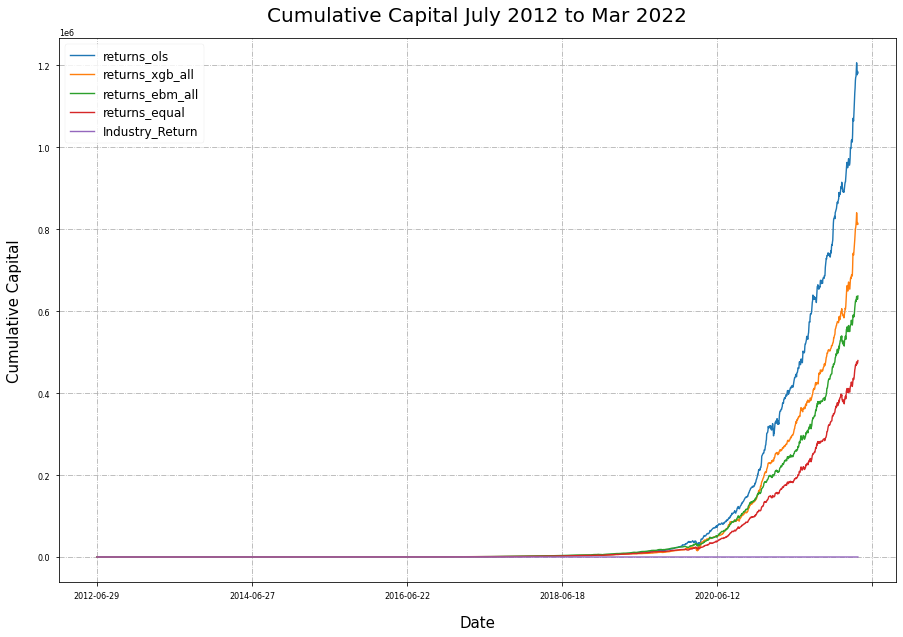

In [ ]:
plt.style.use('seaborn-paper')

plt.figure()
cumulative_ret.plot(x='date',style='-',figsize=(15,10))
plt.grid(True,linestyle='-.')
plt.legend(loc = 'upper left', fontsize='large')
plt.xlabel("Date", labelpad=15,fontsize=15)
plt.ylabel("Cumulative Capital", labelpad=15,fontsize=15)
plt.title("Cumulative Capital July 2012 to Mar 2022", y=1.02, fontsize=20);
plt.show()

In [ ]:
weights_ebm_all = pd.read_csv('weights_ebm_all_quarter.csv')
weights_ebm_all.head()

,Unnamed: 0,Stock,allocation,Quarter,Method
0,8,CYH,0.0234,2012Q2,ebm_all
1,12,EW,0.6290,2012Q2,ebm_all
2,14,HCA,0.1855,2012Q2,ebm_all
3,32,SAVA,0.1435,2012Q2,ebm_all
4,39,UTMD,0.0187,2012Q2,ebm_all


In [ ]:
weights_ebm_all.rename(columns={'Stock':'Ticker'},inplace = True)

In [ ]:
weights_ebm_all

,Unnamed: 0,Ticker,allocation,Quarter,Method
0,8,CYH,0.0234,2012Q2,ebm_all
1,12,EW,0.6290,2012Q2,ebm_all
2,14,HCA,0.1855,2012Q2,ebm_all
3,32,SAVA,0.1435,2012Q2,ebm_all
4,39,UTMD,0.0187,2012Q2,ebm_all
...,...,...,...,...,...
453,33,INVA,0.0148,2022Q1,ebm_all
454,59,SRTS,0.0435,2022Q1,ebm_all
455,68,VIVO,0.1578,2022Q1,ebm_all
456,70,VRTX,0.2775,2022Q1,ebm_all


In [ ]:
dff = pd.read_csv('backtesting_jul20 (4).csv')
dff = dff[['date','adjClose','Quarter','Ticker','pct_chg']].dropna()
dff.head()

,date,adjClose,Quarter,Ticker,pct_chg
183,2012-01-04,46.953720,2012Q1,DGX,-0.002422
184,2012-01-04,18.760000,2012Q1,THC,-0.054435
185,2012-01-04,0.637513,2012Q1,PRPH,-0.016393
186,2012-01-04,2.540000,2012Q1,PDEX,0.000000
187,2012-01-04,15.370000,2012Q1,QDEL,-0.015375


In [ ]:
tar_lastdate = dff.groupby('Quarter')['date'].last().values
tar_lastdate

array(['2012-03-30', '2012-06-29', '2012-09-28', '2012-12-31',
       '2013-03-28', '2013-06-28', '2013-09-30', '2013-12-31',
       '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
       '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
       '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-30',
       '2017-03-31', '2017-06-30', '2017-09-29', '2017-12-29',
       '2018-03-29', '2018-06-29', '2018-09-28', '2018-12-31',
       '2019-03-29', '2019-06-28', '2019-09-30', '2019-12-31',
       '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
       '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
       '2022-03-31'], dtype=object)

In [ ]:
dff_quarter_date = dff[['date','Quarter']]
dff_quarter_date

,date,Quarter
183,2012-01-04,2012Q1
184,2012-01-04,2012Q1
185,2012-01-04,2012Q1
186,2012-01-04,2012Q1
187,2012-01-04,2012Q1
...,...,...
719771,2022-03-31,2022Q1
719772,2022-03-31,2022Q1
719773,2022-03-31,2022Q1
719774,2022-03-31,2022Q1


In [ ]:
dff_quarter_lastdate = dff_quarter_date[dff_quarter_date['date'].isin(tar_lastdate)].drop_duplicates()
#dff_quarter_lastdate = dff_quarter_lastdate.set_index('date')
dff_quarter_lastdate

,date,Quarter
11200,2012-03-30,2012Q1
22950,2012-06-29,2012Q2
34813,2012-09-28,2012Q3
46612,2012-12-31,2012Q4
58275,2013-03-28,2013Q1
70858,2013-06-28,2013Q2
83758,2013-09-30,2013Q3
97008,2013-12-31,2013Q4
110094,2014-03-31,2014Q1
123963,2014-06-30,2014Q2


In [ ]:
results0 = dff_quarter_lastdate.merge(cum_ret_quarter,on='Quarter').set_index('Quarter')
results0 = results0.rename(columns={'date':'Quarter Last date','Cum_ret_ebm_all':'Quarterly_Return_EBM','Cum_ret_xgb_all':'Quarterly_Return_XGB','Cum_ret_ols':'Quarterly_Return_OLS','Cum_ret_equal':'Quarterly_Return_Equal_Weight','Cum_ret_industry':'Quarterly_Returns_S&P500_Health'})
results0

,Quarter Last date,Quarterly_Return_EBM,Quarterly_Return_XGB,Quarterly_Return_OLS,Quarterly_Return_Equal_Weight,Quarterly_Returns_S&P500_Health
Quarter,,,,,,
2012Q2,2012-06-29,0.364974,0.347677,0.364110,0.362669,0.000000
2012Q3,2012-09-28,0.289457,0.518471,0.499763,0.300999,0.055654
2012Q4,2012-12-31,0.221122,0.354822,0.348496,0.177037,-0.005029
2013Q1,2013-03-28,0.406891,0.354814,0.562921,0.372591,0.152219
2013Q2,2013-06-28,0.362689,0.379261,0.431930,0.372150,0.033295
2013Q3,2013-09-30,0.543103,0.335932,0.376944,0.341778,0.063210
2013Q4,2013-12-31,0.833833,0.535381,0.586926,0.812618,0.096038
2014Q1,2014-03-31,0.389372,0.335257,0.361876,0.395362,0.054040
2014Q2,2014-06-30,0.401559,0.457914,0.178494,0.447496,0.040635


In [ ]:
results0 = results0.drop(columns=['Quarterly_Return_EBM','Quarterly_Return_XGB','Quarterly_Return_Equal_Weight'])

In [ ]:
results0 = results0[1:]

In [ ]:
results0 = results0.rename(columns={'Quarterly_Return_OLS':'Quarterly_net_return_rate_OLS','Quarterly_Returns_S&P500_Health':'Quarterly_net_return_rate_S&P500_Health'})

In [ ]:
results0.tail()

,Quarter Last date,Quarterly_net_return_rate_OLS,Quarterly_net_return_rate_S&P500_Health
Quarter,,,
2021Q1,2021-03-31,0.583052,0.027439
2021Q2,2021-06-30,0.339092,0.079833
2021Q3,2021-09-30,0.409939,0.010245
2021Q4,2021-12-31,0.337652,0.107770
2022Q1,2022-03-31,0.351131,-0.029874


In [ ]:
results0['Invested Amount'] = 1
results0['Quarterly_cum_total_return_amt_OLS'] = 1
results0['Quarterly_cum_total_return_amt_S&P500_Health'] = 1
for i in range(len(results0)-1):
    results0['Quarterly_cum_total_return_amt_OLS'].iloc[i] = results0['Invested Amount'][i] + (results0['Invested Amount'][i]*results0['Quarterly_net_return_rate_OLS'][i])
    if i == 0:
        results0['Quarterly_cum_total_return_amt_S&P500_Health'].iloc[i] = results0['Invested Amount'][i] + (results0['Invested Amount'][i]*results0['Quarterly_net_return_rate_S&P500_Health'][i])
    else:
        results0['Quarterly_cum_total_return_amt_S&P500_Health'].iloc[i] = results0['Quarterly_cum_total_return_amt_S&P500_Health'][i-1] + (results0['Quarterly_cum_total_return_amt_S&P500_Health'][i-1]*results0['Quarterly_net_return_rate_S&P500_Health'][i])
    results0['Invested Amount'].iloc[i+1] = results0['Quarterly_cum_total_return_amt_OLS'][i]
results0['Quarterly_cum_total_return_amt_OLS'].iloc[len(results0)-1] = results0['Invested Amount'][len(results0)-1] + (results0['Invested Amount'][len(results0)-1]*results0['Quarterly_net_return_rate_OLS'][len(results0)-1])
results0['Quarterly_cum_total_return_amt_S&P500_Health'].iloc[len(results0)-1] = results0['Invested Amount'][len(results0)-1] + (results0['Invested Amount'][len(results0)-1]*results0['Quarterly_net_return_rate_S&P500_Health'][len(results0)-1])


/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
results0.head()

,Quarter Last date,Quarterly_net_return_rate_OLS,Quarterly_net_return_rate_S&P500_Health,Invested Amount,Quarterly_cum_total_return_amt_OLS,Quarterly_cum_total_return_amt_S&P500_Health
Quarter,,,,,,
2012Q3,2012-09-28,0.499763,0.055654,1.000000,1.499763,1.055654
2012Q4,2012-12-31,0.348496,-0.005029,1.499763,2.022425,1.050345
2013Q1,2013-03-28,0.562921,0.152219,2.022425,3.160891,1.210228
2013Q2,2013-06-28,0.431930,0.033295,3.160891,4.526174,1.250522
2013Q3,2013-09-30,0.376944,0.063210,4.526174,6.232289,1.329567


In [ ]:
results0['Quarter First date'] = ''
for i in range(len(results0)):
    startmonth = ''
    if results0.index[i][5:] == '1':
        startmonth = '01'
    elif results0.index[i][5:] == '2':
        startmonth = '04'
    elif results0.index[i][5:] == '3':
        startmonth = '07'
    elif results0.index[i][5:] == '4':
        startmonth = '10'
    results0['Quarter First date'].iloc[i] = datetime.datetime.strptime(results0.index[i][:4]+'-'+startmonth, '%Y-%m').date() # datetime.datetime.strptime('2020-03', "%Y-%m").date()

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
results0 = results0.reset_index()
results0.head()

,Quarter,Quarter Last date,Quarterly_net_return_rate_OLS,Quarterly_net_return_rate_S&P500_Health,Invested Amount,Quarterly_cum_total_return_amt_OLS,Quarterly_cum_total_return_amt_S&P500_Health,Quarter First date
0,2012Q3,2012-09-28,0.499763,0.055654,1.000000,1.499763,1.055654,2012-07-01
1,2012Q4,2012-12-31,0.348496,-0.005029,1.499763,2.022425,1.050345,2012-10-01
2,2013Q1,2013-03-28,0.562921,0.152219,2.022425,3.160891,1.210228,2013-01-01
3,2013Q2,2013-06-28,0.431930,0.033295,3.160891,4.526174,1.250522,2013-04-01
4,2013Q3,2013-09-30,0.376944,0.063210,4.526174,6.232289,1.329567,2013-07-01


In [ ]:
results0 = results0[['Quarter','Quarter First date','Quarter Last date','Invested Amount','Quarterly_net_return_rate_OLS','Quarterly_cum_total_return_amt_OLS','Quarterly_net_return_rate_S&P500_Health','Quarterly_cum_total_return_amt_S&P500_Health']]

In [ ]:
results0.tail()

,Quarter,Quarter First date,Quarter Last date,Invested Amount,Quarterly_net_return_rate_OLS,Quarterly_cum_total_return_amt_OLS,Quarterly_net_return_rate_S&P500_Health,Quarterly_cum_total_return_amt_S&P500_Health
34,2021Q1,2021-01-01,2021-03-31,218678.868013,0.583052,3.461801e+05,0.027439,3.086351
35,2021Q2,2021-04-01,2021-06-30,346180.081143,0.339092,4.635670e+05,0.079833,3.332743
36,2021Q3,2021-07-01,2021-09-30,463566.980595,0.409939,6.536011e+05,0.010245,3.366889
37,2021Q4,2021-10-01,2021-12-31,653601.109953,0.337652,8.742910e+05,0.107770,3.729740
38,2022Q1,2022-01-01,2022-03-31,874291.022548,0.351131,1.181281e+06,-0.029874,848172.700417


In [ ]:
results0.to_excel('1-3. Return_Quarterly - Worksheet Quarterly.xlsx')

In [ ]:
tar_date = dff.groupby('Quarter')['date'].first().values
tar_date

array(['2012-01-04', '2012-04-02', '2012-07-02', '2012-10-01',
       '2013-01-02', '2013-04-01', '2013-07-01', '2013-10-01',
       '2014-01-02', '2014-04-01', '2014-07-01', '2014-10-01',
       '2015-01-02', '2015-04-01', '2015-07-01', '2015-10-01',
       '2016-01-04', '2016-04-01', '2016-07-01', '2016-10-03',
       '2017-01-03', '2017-04-03', '2017-07-03', '2017-10-02',
       '2018-01-02', '2018-04-02', '2018-07-02', '2018-10-01',
       '2019-01-02', '2019-04-01', '2019-07-01', '2019-10-01',
       '2020-01-02', '2020-04-01', '2020-07-01', '2020-10-01',
       '2021-01-04', '2021-04-01', '2021-07-01', '2021-10-01',
       '2022-01-03'], dtype=object)

In [ ]:
dff['Ticker2'] = dff['Ticker']

In [ ]:
dff = dff.set_index('date')
dff.head()

,adjClose,Quarter,Ticker,pct_chg,Ticker2
date,,,,,
2012-01-04,46.953720,2012Q1,DGX,-0.002422,DGX
2012-01-04,18.760000,2012Q1,THC,-0.054435,THC
2012-01-04,0.637513,2012Q1,PRPH,-0.016393,PRPH
2012-01-04,2.540000,2012Q1,PDEX,0.000000,PDEX
2012-01-04,15.370000,2012Q1,QDEL,-0.015375,QDEL


In [ ]:
dff.drop(columns=['pct_chg'],inplace = True)

In [ ]:
dff.groupby(by=['Ticker']).shift(1)

,adjClose,Quarter,Ticker2
date,,,
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
...,...,...,...
2022-03-31,46.246448,2022Q1,LMAT
2022-03-31,19.440000,2022Q1,RVNC
2022-03-31,24.070000,2022Q1,CCCC


In [ ]:
dff = dff.groupby(by=['Ticker']).shift(1)
dff

,adjClose,Quarter,Ticker2
date,,,
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
2012-01-04,NaN,NaN,NaN
...,...,...,...
2022-03-31,46.246448,2022Q1,LMAT
2022-03-31,19.440000,2022Q1,RVNC
2022-03-31,24.070000,2022Q1,CCCC


In [ ]:
dff = dff.reset_index()
dff.head()

,date,adjClose,Quarter,Ticker2
0,2012-01-04,NaN,NaN,NaN
1,2012-01-04,NaN,NaN,NaN
2,2012-01-04,NaN,NaN,NaN
3,2012-01-04,NaN,NaN,NaN
4,2012-01-04,NaN,NaN,NaN


In [ ]:
dff = dff.rename(columns={'Ticker2':'Ticker'})
dff

,date,adjClose,Quarter,Ticker
0,2012-01-04,NaN,NaN,NaN
1,2012-01-04,NaN,NaN,NaN
2,2012-01-04,NaN,NaN,NaN
3,2012-01-04,NaN,NaN,NaN
4,2012-01-04,NaN,NaN,NaN
...,...,...,...,...
719346,2022-03-31,46.246448,2022Q1,LMAT
719347,2022-03-31,19.440000,2022Q1,RVNC
719348,2022-03-31,24.070000,2022Q1,CCCC
719349,2022-03-31,39.220000,2022Q1,VCEL


In [ ]:
n_dff = dff[dff['date'].isin(tar_date)]
n_dff

,date,adjClose,Quarter,Ticker
0,2012-01-04,NaN,NaN,NaN
1,2012-01-04,NaN,NaN,NaN
2,2012-01-04,NaN,NaN,NaN
3,2012-01-04,NaN,NaN,NaN
4,2012-01-04,NaN,NaN,NaN
...,...,...,...,...
693563,2022-01-03,16.719999,2021Q4,ISEE
693564,2022-01-03,44.599998,2021Q4,DNLI
693565,2022-01-03,6.942857,2021Q4,PMD
693566,2022-01-03,45.479999,2021Q4,CDNA


In [ ]:
n_dff.isnull().sum()

date          0
adjClose    190
Quarter     190
Ticker      190
dtype: int64

In [ ]:
a = weights_ebm_all.merge(n_dff,on = ['Quarter','Ticker'])[['Ticker','Quarter','adjClose']]
a

,Ticker,Quarter,adjClose
0,CYH,2012Q2,22.971405
1,EW,2012Q2,17.216667
2,HCA,2012Q2,25.176656
3,SAVA,2012Q2,25.111351
4,UTMD,2012Q2,28.179317
...,...,...,...
443,NUS,2021Q4,49.913876
444,PFE,2021Q4,58.130367
445,SRTS,2021Q4,7.220000
446,UTMD,2021Q4,99.322983


In [ ]:
a.isnull().sum()

Ticker      0
Quarter     0
adjClose    0
dtype: int64

In [ ]:
a.to_csv('portfolio_price_new.csv')

In [ ]:
cum_ret_month

,Month,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal
0,2012-04,0.127093,0.073301,0.509384,0.107042
1,2012-05,0.001048,0.070937,-0.125477,0.036681
2,2012-06,0.209790,0.172467,0.033424,0.187357
3,2012-07,0.088923,0.115298,0.174004,0.096186
4,2012-08,0.126816,0.180706,0.195992,0.122537
...,...,...,...,...,...
115,2021-11,0.148280,0.090795,0.078642,0.148310
116,2021-12,0.127655,0.111691,0.146513,0.127621
117,2022-01,0.053140,0.042770,0.040563,0.031573
118,2022-02,0.066740,0.142040,0.095589,0.081086


In [ ]:
spp_month = pd.DataFrame()
sp_cum = []
month = []
for i in new_sp['Month'].unique():
    month.append(i)
    sp_cum.append(((new_sp[new_sp['Month']==i]['S&P 500 Health Care (Sector)']+1).cumprod()-1).tail(1).values[0])
spp_month['Month'] = month
spp_month['Cum_ret_industry'] = sp_cum

In [ ]:
spp_month = spp_month.fillna(0)
spp_month.head()

,Month,Cum_ret_industry
0,2012-06,0.000000
1,2012-07,0.009325
2,2012-08,0.007553
3,2012-09,0.038061
4,2012-10,-0.004255


In [ ]:
for i in range(len(spp_month['Month'])):
    spp_month['Month'][i] = spp_month['Month'][i].strftime('%Y-%m') 

/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
cum_ret_month

,Month,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal
0,2012-04,0.127093,0.073301,0.509384,0.107042
1,2012-05,0.001048,0.070937,-0.125477,0.036681
2,2012-06,0.209790,0.172467,0.033424,0.187357
3,2012-07,0.088923,0.115298,0.174004,0.096186
4,2012-08,0.126816,0.180706,0.195992,0.122537
...,...,...,...,...,...
115,2021-11,0.148280,0.090795,0.078642,0.148310
116,2021-12,0.127655,0.111691,0.146513,0.127621
117,2022-01,0.053140,0.042770,0.040563,0.031573
118,2022-02,0.066740,0.142040,0.095589,0.081086


In [ ]:
cum_ret_month_all = cum_ret_month.merge(spp_month,how = 'left',on='Month')
#cum_ret_month_all = cum_ret_month_all.fillna(0)
cum_ret_month_all = cum_ret_month_all.dropna()
cum_ret_month_all

,Month,Cum_ret_ebm_all,Cum_ret_xgb_all,Cum_ret_ols,Cum_ret_equal,Cum_ret_industry
2,2012-06,0.209790,0.172467,0.033424,0.187357,0.000000
3,2012-07,0.088923,0.115298,0.174004,0.096186,0.009325
4,2012-08,0.126816,0.180706,0.195992,0.122537,0.007553
5,2012-09,0.050888,0.153117,0.068132,0.057285,0.038061
6,2012-10,0.050362,0.084867,0.076022,0.048026,-0.004255
...,...,...,...,...,...,...
115,2021-11,0.148280,0.090795,0.078642,0.148310,-0.031341
116,2021-12,0.127655,0.111691,0.146513,0.127621,0.088364
117,2022-01,0.053140,0.042770,0.040563,0.031573,-0.069018
118,2022-02,0.066740,0.142040,0.095589,0.081086,-0.011278


In [ ]:
cum_ret_month_all.isnull().sum()

Month               0
Cum_ret_ebm_all     0
Cum_ret_xgb_all     0
Cum_ret_ols         0
Cum_ret_equal       0
Cum_ret_industry    0
dtype: int64

In [ ]:
cum_ret_month_ols = cum_ret_month_all.iloc[:,np.r_[0,3,-1]]
cum_ret_month_ols = cum_ret_month_ols.rename(columns={'Cum_ret_ols':'Monthly_Net_OLS','Cum_ret_industry':'Monthly_Net_S&P500'})
cum_ret_month_ols.head()

,Month,Monthly_Net_OLS,Monthly_Net_S&P500
2,2012-06,0.033424,0.000000
3,2012-07,0.174004,0.009325
4,2012-08,0.195992,0.007553
5,2012-09,0.068132,0.038061
6,2012-10,0.076022,-0.004255


In [ ]:
cum_ret_month_ols

,Month,Monthly_Net_OLS,Monthly_Net_S&P500
2,2012-06,0.033424,0.000000
3,2012-07,0.174004,0.009325
4,2012-08,0.195992,0.007553
5,2012-09,0.068132,0.038061
6,2012-10,0.076022,-0.004255
...,...,...,...
115,2021-11,0.078642,-0.031341
116,2021-12,0.146513,0.088364
117,2022-01,0.040563,-0.069018
118,2022-02,0.095589,-0.011278


In [ ]:
cum_ret_month_ols.loc[cum_ret_month_ols['Month']=='2012-06','Monthly_cum_total_return_OLS'] = 1
cum_ret_month_ols.loc[cum_ret_month_ols['Month']=='2012-06','Monthly_cum_total_return_S&P500'] = 1
# cum_ret_month_ols['Monthly_cum_total_return_ols'][0] = 100
# cum_ret_month_ols['Monthly_cum_total_return_S&P500'] = ''
# cum_ret_month_ols['Monthly_cum_total_return_S&P500'][0] = 100
temp = '2012-06'
cum_ret_month_ols.loc[cum_ret_month_ols['Month']=='2012-06','Monthly_Net_OLS'] = 0
for i in cum_ret_month_ols['Month'][1:]:
    cum_ret_month_ols.loc[cum_ret_month_ols['Month']==i,'Monthly_cum_total_return_OLS'] = (cum_ret_month_ols.loc[cum_ret_month_ols['Month']==temp,'Monthly_cum_total_return_OLS']).values*(1+cum_ret_month_ols.loc[cum_ret_month_ols['Month']==i,'Monthly_Net_OLS']).values
    cum_ret_month_ols.loc[cum_ret_month_ols['Month']==i,'Monthly_cum_total_return_S&P500'] = (cum_ret_month_ols.loc[cum_ret_month_ols['Month']==temp,'Monthly_cum_total_return_S&P500']).values*(1+cum_ret_month_ols.loc[cum_ret_month_ols['Month']==i,'Monthly_Net_S&P500']).values
    #cum_ret_month_ols.loc[cum_ret_month_ols['Month']==,'Invested Amount'] = cum_ret_month_ols.loc[cum_ret_month_ols['Month']==i,'Monthly_cum_total_return_OLS']
    temp = i
    

In [ ]:
cum_ret_month_ols['Invested Amount'] = cum_ret_month_ols["Monthly_cum_total_return_OLS"].shift(1)
cum_ret_month_ols = cum_ret_month_ols.fillna(0)
target_ols = cum_ret_month_ols[['Month','Invested Amount','Monthly_Net_OLS','Monthly_cum_total_return_OLS','Monthly_Net_S&P500','Monthly_cum_total_return_S&P500']]
target_ols

,Month,Invested Amount,Monthly_Net_OLS,Monthly_cum_total_return_OLS,Monthly_Net_S&P500,Monthly_cum_total_return_S&P500
2,2012-06,0.000000,0.000000,1.000000e+00,0.000000,1.000000
3,2012-07,1.000000,0.174004,1.174004e+00,0.009325,1.009325
4,2012-08,1.174004,0.195992,1.404099e+00,0.007553,1.016948
5,2012-09,1.404099,0.068132,1.499763e+00,0.038061,1.055654
6,2012-10,1.499763,0.076022,1.613779e+00,-0.004255,1.051162
...,...,...,...,...,...,...
115,2021-11,706967.931931,0.078642,7.625655e+05,-0.031341,3.426922
116,2021-12,762565.479888,0.146513,8.742910e+05,0.088364,3.729740
117,2022-01,874291.022548,0.040563,9.097548e+05,-0.069018,3.472321
118,2022-02,909754.784947,0.095589,9.967175e+05,-0.011278,3.433161


In [ ]:
target_ols = target_ols.rename(columns = {'Monthly_Net_OLS':'Monthly_net_return_rate_OLS','Monthly_cum_total_return_OLS':'Monthly_cum_total_return_amt_OLS','Monthly_Net_S&P500':'Monthly_net_return_rate_S&P500_Health','Monthly_cum_total_return_S&P500':'Monthly_cum_total_return_amt_S&P500_Health'})
target_ols

,Month,Invested Amount,Monthly_net_return_rate_OLS,Monthly_cum_total_return_amt_OLS,Monthly_net_return_rate_S&P500_Health,Monthly_cum_total_return_amt_S&P500_Health
2,2012-06,0.000000,0.000000,1.000000e+00,0.000000,1.000000
3,2012-07,1.000000,0.174004,1.174004e+00,0.009325,1.009325
4,2012-08,1.174004,0.195992,1.404099e+00,0.007553,1.016948
5,2012-09,1.404099,0.068132,1.499763e+00,0.038061,1.055654
6,2012-10,1.499763,0.076022,1.613779e+00,-0.004255,1.051162
...,...,...,...,...,...,...
115,2021-11,706967.931931,0.078642,7.625655e+05,-0.031341,3.426922
116,2021-12,762565.479888,0.146513,8.742910e+05,0.088364,3.729740
117,2022-01,874291.022548,0.040563,9.097548e+05,-0.069018,3.472321
118,2022-02,909754.784947,0.095589,9.967175e+05,-0.011278,3.433161


In [ ]:
target_ols.to_excel('1-2. Return_Monthly - Worksheet Monthly.xlsx')

In [ ]:
cum_ret_year=cum_ret_year.merge(spp_year,on='Year')

In [ ]:

cum_ret_year_ols = cum_ret_year.iloc[:,np.r_[0,3,-1]]
cum_ret_year_ols = cum_ret_year_ols.rename(columns={'Cum_ret_ols':'Yearly_net_return_rate_OLS','Cum_ret_industry':'Yearly_net_return_rate_S&P500_Health'})


cum_ret_year_ols.head()

,Year,Yearly_net_return_rate_OLS,Yearly_net_return_rate_S&P500_Health
0,2012,1.022425,0.050345
1,2013,3.890260,0.387407
2,2014,1.807827,0.233022
3,2015,2.622948,0.052098
4,2016,2.293495,-0.043589


In [ ]:
cum_ret_year_ols['Invested Amount'] = 1
cum_ret_year_ols['Yearly_cum_total_return_amt_OLS'] = 1

In [ ]:
cum_ret_year_ols.describe()

,Yearly_net_return_rate_OLS,Yearly_net_return_rate_S&P500_Health,Invested Amount,Yearly_cum_total_return_amt_OLS
count,11.000000,11.000000,11.0,11.0
mean,2.948905,0.130825,1.0,1.0
std,1.856017,0.131420,0.0,0.0
min,0.351131,-0.043589,1.0,1.0
25%,2.050661,0.048627,1.0,1.0
50%,2.622948,0.114299,1.0,1.0
75%,3.617973,0.216529,1.0,1.0
max,7.168860,0.387407,1.0,1.0


In [ ]:
# cum_ret_year_ols.loc[cum_ret_year_ols['Year']=='2012','yearly_cum_total_return_OLS'] = 1
# cum_ret_year_ols.loc[cum_ret_year_ols['Year']=='2012','yearly_cum_total_return_S&P500'] = 1
# # cum_ret_year_ols['yearly_cum_total_return_ols'][0] = 100
# # cum_ret_year_ols['yearly_cum_total_return_S&P500'] = ''
# # cum_ret_year_ols['yearly_cum_total_return_S&P500'][0] = 100
# temp = '2012'

for i in range(len(cum_ret_year_ols)-1):
    cum_ret_year_ols['Yearly_cum_total_return_amt_OLS'].iloc[i] = cum_ret_year_ols['Invested Amount'][i] + (cum_ret_year_ols['Invested Amount'][i]*cum_ret_year_ols['Yearly_net_return_rate_OLS'][i])
    cum_ret_year_ols['Invested Amount'].iloc[i+1] = cum_ret_year_ols['Yearly_cum_total_return_amt_OLS'][i]
cum_ret_year_ols['Yearly_cum_total_return_amt_OLS'].iloc[len(cum_ret_year_ols)-1] = cum_ret_year_ols['Invested Amount'][len(cum_ret_year_ols)-1] + (cum_ret_year_ols['Invested Amount'][len(cum_ret_year_ols)-1]*cum_ret_year_ols['Yearly_net_return_rate_OLS'][len(cum_ret_year_ols)-1])

    
# cum_ret_year_ols.loc[cum_ret_year_ols['Year']=='2012','yearly_Net_OLS'] = 0
# for i in cum_ret_year_ols['Year'][1:]:
#     cum_ret_year_ols.loc[cum_ret_year_ols['Year']==i,'yearly_cum_total_return_OLS'] = (cum_ret_year_ols.loc[cum_ret_year_ols['Year']==temp,'yearly_cum_total_return_OLS']).values*(1+cum_ret_year_ols.loc[cum_ret_year_ols['Year']==i,'yearly_Net_OLS']).values
#     cum_ret_year_ols.loc[cum_ret_year_ols['Year']==i,'yearly_cum_total_return_S&P500'] = (cum_ret_year_ols.loc[cum_ret_year_ols['Year']==temp,'yearly_cum_total_return_S&P500']).values*(1+cum_ret_year_ols.loc[cum_ret_year_ols['Year']==i,'yearly_Net_S&P500']).values
#     #cum_ret_year_ols.loc[cum_ret_year_ols['year']==,'Invested Amount'] = cum_ret_year_ols.loc[cum_ret_year_ols['year']==i,'yearly_cum_total_return_OLS']
#     temp = i

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
cum_ret_year_ols

,Year,Yearly_net_return_rate_OLS,Yearly_net_return_rate_S&P500_Health,Invested Amount,Yearly_cum_total_return_amt_OLS
0,2012,1.022425,0.050345,1.000000,2.022425e+00
1,2013,3.890260,0.387407,2.022425,9.890183e+00
2,2014,1.807827,0.233022,9.890183,2.776992e+01
3,2015,2.622948,0.052098,27.769918,1.006090e+02
4,2016,2.293495,-0.043589,100.608972,3.313551e+02
5,2017,3.345686,0.200035,331.355145,1.439965e+03
6,2018,2.294721,0.046909,1439.965268,4.744283e+03
7,2019,4.642541,0.186800,4744.283401,2.676981e+04
8,2020,7.168860,0.114299,26769.814395,2.186789e+05
9,2021,2.998059,0.241622,218678.868013,8.742910e+05


In [ ]:
cum_ret_year_ols = cum_ret_year_ols[['Year', 'Invested Amount', 'Yearly_net_return_rate_OLS', 'Yearly_cum_total_return_amt_OLS', 'Yearly_net_return_rate_S&P500_Health']]

In [ ]:
cum_ret_year_ols.to_excel('1-4. Return_Yearly - Worksheet Yearly.xlsx')

In [ ]:
cum_ret_year_ols.head()

,Year,Invested Amount,Yearly_net_return_rate_OLS,Yearly_cum_total_return_amt_OLS,Yearly_net_return_rate_S&P500_Health
0,2012,1.000000,1.022425,2.022425,0.050345
1,2013,2.022425,3.890260,9.890183,0.387407
2,2014,9.890183,1.807827,27.769918,0.233022
3,2015,27.769918,2.622948,100.608972,0.052098
4,2016,100.608972,2.293495,331.355145,-0.043589


In [ ]:
Daily_cum = full[['returns_ols', 'Industry_Return']]
#Daily_cum['date']= Daily_cum.index
Daily_cum=Daily_cum.reset_index()

In [ ]:
Daily_cum

,date,returns_ols,Industry_Return
0,2012-06-29,0.000000,0.000000
1,2012-07-02,0.014876,0.003018
2,2012-07-03,0.008390,-0.000905
3,2012-07-05,0.011304,-0.005547
4,2012-07-06,0.015808,-0.007171
...,...,...,...
2450,2022-03-25,0.012190,0.005159
2451,2022-03-28,-0.013063,0.007360
2452,2022-03-29,-0.011286,0.005532
2453,2022-03-30,0.006872,0.002211


In [ ]:
cum_ret_daily_ols = cumulative_ret.iloc[:,np.r_[0,1,-1]]
cum_ret_daily_ols = cum_ret_daily_ols.rename(columns={'returns_ols':'Daily_cum_total_return_amt_OLS','Industry_Return':'Daily_cum_total_return_amt_S&P500_Health'})
cum_ret_daily_ols= cum_ret_daily_ols.merge(Daily_cum)
cum_ret_daily_ols = cum_ret_daily_ols.rename(columns={'returns_ols':'Daily_net_return_rate_OLS','Industry_Return':'Daily_net_return_rate_S&P500_Health'})
cum_ret_daily_ols['Invested Amount'] = cum_ret_daily_ols["Daily_cum_total_return_amt_OLS"].shift(1)
cum_ret_daily_ols = cum_ret_daily_ols.fillna(0)
cum_ret_daily_ols.head()

,date,Daily_cum_total_return_amt_OLS,Daily_cum_total_return_amt_S&P500_Health,Daily_net_return_rate_OLS,Daily_net_return_rate_S&P500_Health,Invested Amount
0,2012-06-29,1.000000,1.000000,0.000000,0.000000,0.000000
1,2012-07-02,1.014876,1.003018,0.014876,0.003018,1.000000
2,2012-07-03,1.023391,1.002110,0.008390,-0.000905,1.014876
3,2012-07-05,1.034959,0.996551,0.011304,-0.005547,1.023391
4,2012-07-06,1.051320,0.989405,0.015808,-0.007171,1.034959


In [ ]:
import openpyxl
cum_ret_daily_ols=cum_ret_daily_ols.rename(columns={'date':'Date'})
cum_ret_daily_ols=cum_ret_daily_ols[['Date','Invested Amount','Daily_net_return_rate_OLS','Daily_cum_total_return_amt_OLS','Daily_net_return_rate_S&P500_Health','Daily_cum_total_return_amt_S&P500_Health']]
cum_ret_daily_ols.to_excel('1-1. Return_Daily - Worksheet Daily.xlsx')

In [ ]:
data = pd.read_csv('backtesting_jul20 (4).csv')
data = data[['date','Quarter','Ticker','adjClose']]
data['date'] = pd.to_datetime(data['date'])
lastdate = data.groupby('Quarter')['date'].last().values
lastdate = data[data['date'].isin(lastdate)]
lastdate = lastdate[['adjClose','Quarter','Ticker','date']].rename(columns={"date": "Quarter Last Date","adjClose": "Stock Price" }).reset_index(drop=True)
firstdate = data.groupby('Quarter')['date'].first().values
firstdate = data[data['date'].isin(firstdate)]
firstdate = firstdate[['adjClose','Quarter','Ticker','date']].rename(columns={"date": "Quarter First Date","adjClose": "Purchased Stock Price" }).reset_index(drop=True)
firstdate = firstdate.merge(lastdate, on=['Quarter','Ticker'])
s_e_total = firstdate[firstdate['Quarter']!= '2012Q1']
s_e_total = s_e_total[s_e_total['Quarter']!= '2012Q2']


In [ ]:
s_e_total.head(100)

,Purchased Stock Price,Quarter,Ticker,Quarter First Date,Stock Price,Quarter Last Date
368,2.120000,2012Q3,ELMD,2012-07-02,1.450000,2012-09-28
369,25.280001,2012Q3,MYGN,2012-07-02,26.950001,2012-09-28
370,11.892973,2012Q3,NEOG,2012-07-02,10.677670,2012-09-28
371,10.731030,2012Q3,HSKA,2012-07-02,9.020000,2012-09-28
372,2.250000,2012Q3,PACB,2012-07-02,1.830000,2012-09-28
...,...,...,...,...,...,...
463,20.680000,2012Q3,THC,2012-07-02,25.080000,2012-09-28
464,78.500000,2012Q3,WAT,2012-07-02,83.330000,2012-09-28
465,9.000000,2012Q3,SMTI,2012-07-02,14.000000,2012-09-28
466,1.810000,2012Q3,ACAD,2012-07-02,2.530000,2012-09-28


In [ ]:
weights_ols

,Ticker,allocation,Quarter,Method
2,CCXI,0.3192,2012Q2,ols
6,FONR,0.2758,2012Q2,ols
8,ICUI,0.4050,2012Q2,ols
2,AMN,0.1436,2012Q3,ols
3,ANIK,0.0337,2012Q3,ols
...,...,...,...,...
37,ICCC,0.0916,2022Q1,ols
46,MCK,0.1581,2022Q1,ols
51,PCRX,0.1614,2022Q1,ols
58,RDUS,0.0292,2022Q1,ols


In [ ]:
weights_ols.rename(columns={'Stock':'Ticker'},inplace = True)

w=pd.merge(weights_ols, s_e_total, on=['Quarter','Ticker'])

In [ ]:
c= pd.read_csv('companyname.csv')
c=c.rename(columns={"symbol": "Ticker"})

In [ ]:
dict_c = {}
for i in range(len(c)):
    dict_c[c['Ticker'][i]] = c['companyName'][i]

In [ ]:
dict_c

{'TXG': '10x Genomics, Inc.',
 'TSVT': '2seventy bio, Inc.',
 'FDMT': '4D Molecular Therapeutics, Inc.',
 'MASS': '908 Devices Inc.',
 'AADI': 'Aadi Bioscience, Inc.',
 'ABT': 'Abbott Laboratories',
 'ABBV': 'AbbVie Inc.',
 'ABMD': 'Abiomed, Inc.',
 'ACHC': 'Acadia Healthcare Company, Inc.',
 'ACAD': 'ACADIA Pharmaceuticals Inc.',
 'ACHV': 'Achieve Life Sciences, Inc.',
 'ACRS': 'Aclaris Therapeutics, Inc.',
 'ATNM': 'Actinium Pharmaceuticals, Inc.',
 'AHCO': 'AdaptHealth Corp.',
 'ADPT': 'Adaptive Biotechnologies Corporation',
 'ADUS': 'Addus HomeCare Corporation',
 'ACET': 'Adicet Bio, Inc.',
 'AERI': 'Aerie Pharmaceuticals, Inc.',
 'AVTE': 'Aerovate Therapeutics, Inc.',
 'AGIO': 'Agios Pharmaceuticals, Inc.',
 'AIRS': 'AirSculpt Technologies, Inc.',
 'AKRO': 'Akero Therapeutics, Inc.',
 'ALBO': 'Albireo Pharma, Inc.',
 'ALEC': 'Alector, Inc.',
 'ALGN': 'Align Technology, Inc.',
 'ALHC': 'Alignment Healthcare, Inc.',
 'ALIM': 'Alimera Sciences, Inc.',
 'ALLO': 'Allogene Therapeutics,

In [ ]:
w['companyName'] = ''
for i in range(len(w)):
    w['companyName'].iloc[i] = dict_c.get(w['Ticker'][i])
#     p=c.loc[c['Ticker'] == i, 'companyName'].reset_index()
#     w['companyName']=w.append(p)

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
w.head()

,Ticker,allocation,Quarter,Method,Purchased Stock Price,Quarter First Date,Stock Price,Quarter Last Date,companyName
0,AMN,0.1436,2012Q3,ols,6.080000,2012-07-02,10.060000,2012-09-28,"AMN Healthcare Services, Inc."
1,ANIK,0.0337,2012Q3,ols,14.870000,2012-07-02,15.020000,2012-09-28,"Anika Therapeutics, Inc."
2,CDMO,0.0177,2012Q3,ols,3.062487,2012-07-02,5.438555,2012-09-28,"Avid Bioservices, Inc."
3,CLDX,0.0294,2012Q3,ols,82.050003,2012-07-02,94.500000,2012-09-28,"Celldex Therapeutics, Inc."
4,CYTK,0.0900,2012Q3,ols,3.720000,2012-07-02,4.980000,2012-09-28,"Cytokinetics, Incorporated"


In [ ]:
ret_ols =cumulative_ret[['returns_ols', 'date']]
ret_ols['Quarter'] = pd.PeriodIndex(ret_ols['date'] ,freq='Q')
lastdate = ret_ols.groupby('Quarter')['date'].last().values
lastdate = ret_ols[ret_ols['date'].isin(lastdate)]
lastdate = lastdate.rename(columns={"date": "last_date","returns_ols": "last_returns_ols" }).reset_index(drop=True)
ret_ols = lastdate[['last_returns_ols','Quarter']]

/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
ret_ols = ret_ols.set_index('Quarter')
ret_ols=ret_ols.shift(1).dropna()
ret_ols['Quarter'] = ret_ols.index

In [ ]:
ret_ols

,last_returns_ols,Quarter
Quarter,,
2012Q3,1.000000,2012Q3
2012Q4,1.499763,2012Q4
2013Q1,2.022425,2013Q1
2013Q2,3.160891,2013Q2
2013Q3,4.526174,2013Q3
2013Q4,6.232289,2013Q4
2014Q1,9.890183,2014Q1
2014Q2,13.469208,2014Q2
2014Q3,15.873384,2014Q3


In [ ]:

dict_ret_last = {}
for i in range(len(ret_ols)):
    dict_ret_last[str(ret_ols['Quarter'][i])] = ret_ols['last_returns_ols'][i]

In [ ]:
w[['Quarterly Total Invested Amount']] = ""
for i in range(len(w)):
    w['Quarterly Total Invested Amount'].iloc[i] = dict_ret_last.get(w['Quarter'][i])

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
w.head()

,Ticker,allocation,Quarter,Method,Purchased Stock Price,Quarter First Date,Stock Price,Quarter Last Date,companyName,Quarterly Total Invested Amount
0,AMN,0.1436,2012Q3,ols,6.080000,2012-07-02,10.060000,2012-09-28,"AMN Healthcare Services, Inc.",1
1,ANIK,0.0337,2012Q3,ols,14.870000,2012-07-02,15.020000,2012-09-28,"Anika Therapeutics, Inc.",1
2,CDMO,0.0177,2012Q3,ols,3.062487,2012-07-02,5.438555,2012-09-28,"Avid Bioservices, Inc.",1
3,CLDX,0.0294,2012Q3,ols,82.050003,2012-07-02,94.500000,2012-09-28,"Celldex Therapeutics, Inc.",1
4,CYTK,0.0900,2012Q3,ols,3.720000,2012-07-02,4.980000,2012-09-28,"Cytokinetics, Incorporated",1


In [ ]:
w['Total Cost'] = w['Quarterly Total Invested Amount']*w['allocation']

In [ ]:
w['Shares Bought'] = w['Total Cost']/w['Purchased Stock Price']

In [ ]:
w['Total Market Value'] = w['Stock Price']*w['Shares Bought']

In [ ]:
w['Gain/Loss'] = w['Total Market Value'] - w['Total Cost']

In [ ]:
w['ROI'] = w['Gain/Loss']/w['Total Cost']

In [ ]:
w.drop(columns='Method')

,Ticker,allocation,Quarter,Purchased Stock Price,Quarter First Date,Stock Price,Quarter Last Date,companyName,Quarterly Total Invested Amount,Total Cost,Shares Bought,Total Market Value,Gain/Loss,ROI
0,AMN,0.1436,2012Q3,6.080000,2012-07-02,10.060000,2012-09-28,"AMN Healthcare Services, Inc.",1,0.1436,0.0236184,0.237601,0.0940013,0.654605
1,ANIK,0.0337,2012Q3,14.870000,2012-07-02,15.020000,2012-09-28,"Anika Therapeutics, Inc.",1,0.0337,0.00226631,0.0340399,0.000339946,0.0100874
2,CDMO,0.0177,2012Q3,3.062487,2012-07-02,5.438555,2012-09-28,"Avid Bioservices, Inc.",1,0.0177,0.00577962,0.0314328,0.0137328,0.775862
3,CLDX,0.0294,2012Q3,82.050003,2012-07-02,94.500000,2012-09-28,"Celldex Therapeutics, Inc.",1,0.0294,0.000358318,0.0338611,0.00446106,0.151737
4,CYTK,0.0900,2012Q3,3.720000,2012-07-02,4.980000,2012-09-28,"Cytokinetics, Incorporated",1,0.09,0.0241935,0.120484,0.0304839,0.33871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,ICCC,0.0916,2022Q1,8.190700,2022-01-03,9.650000,2022-03-31,ImmuCell Corporation,874291,80085.1,9777.56,94353.5,14268.4,0.178165
467,MCK,0.1581,2022Q1,247.676575,2022-01-03,306.130000,2022-03-31,McKesson Corporation,874291,138225,558.088,170848,32622.2,0.236007
468,PCRX,0.1614,2022Q1,61.200000,2022-01-03,76.320000,2022-03-31,"Pacira BioSciences, Inc.",874291,141111,2305.73,175973,34862.6,0.247059
469,RDUS,0.0292,2022Q1,6.930000,2022-01-03,8.830000,2022-03-31,"Radius Health, Inc.",874291,25529.3,3683.88,32528.7,6999.37,0.27417


In [ ]:
w.rename(columns={'allocation':'Weight', 'companyName':'Company Name', 'Ticker':'Stock_OLS'},inplace = True)
w = w[['Quarter', 'Stock_OLS', 'Company Name', 'Quarter First Date', 'Quarterly Total Invested Amount', 'Purchased Stock Price', 'Weight', 'Shares Bought', 'Total Cost', 'Quarter Last Date', 'Stock Price', 'Total Market Value', 'Gain/Loss', 'ROI']]
# Quarter	Stock_OLS	Company Name	Quarter First Date 		Quarterly Total Invested Amount	Purchased Stock Price	Weight	Shares Bought	 Total Cost 	Quarter Last Date 	Stock Price	Shares	 Total Market Value 	Gain/Loss	ROI

In [ ]:
len(w)

471

In [ ]:
import openpyxl
w.to_excel('2-2. Holding Company Buying & Selling Info - Worksheet (1) & (2).xlsx')

In [ ]:
w.rename(columns={'Weight':'Allocation_OLS'},inplace = True)
alloc = w[['Quarter','Quarter First Date','Quarter Last Date','Stock_OLS','Company Name','Allocation_OLS']]
# Quarterly_portfolio_weights_ols 
alloc.to_excel('2-1. Quarterly_portfolio_weights_ols - Worksheet] Quarterly Weights.xlsx')

In [ ]:
data['companyName'] = ''
for i in range(len(data)):
    data['companyName'].iloc[i] = dict_c.get(data['Ticker'][i])
data.to_excel('2-3. Stock_data_raw - Worksheet Line Charts & Search & Price History.xlsx')

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


KeyboardInterrupt: 

In [ ]:
data.head()

In [ ]:
port_sum=cum_ret_daily_ols[['Date', 'Daily_cum_total_return_amt_OLS']]
port_sum['Quarter'] = pd.PeriodIndex(port_sum['Date'] ,freq='Q')
port_sum.head()

/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Daily_cum_total_return_amt_OLS,Quarter
0,2012-06-29,1.000000,2012Q2
1,2012-07-02,1.014876,2012Q3
2,2012-07-03,1.023391,2012Q3
3,2012-07-05,1.034959,2012Q3
4,2012-07-06,1.051320,2012Q3


In [ ]:
port_sum[['Invested Amount']] = ''
for i in range(len(port_sum)):
    port_sum['Invested Amount'].iloc[i] = dict_ret_last.get(str(port_sum['Quarter'][i]))

/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [ ]:
from pandas.tseries.offsets import DateOffset
port_sum['Investment Gain/ Loss'] = port_sum['Daily_cum_total_return_amt_OLS']-port_sum['Invested Amount']
port_sum['Return On Investment'] = port_sum['Investment Gain/ Loss']/port_sum['Invested Amount']
port_sum['Percent (%) Change in Daily Return'] =  port_sum['Return On Investment'].diff(1)
port_sum['Date']= pd.to_datetime(port_sum['Date']) 
port_sum['Previous Quarter']= port_sum.Date - DateOffset(months=3)
port_sum['Previous Quarter']= pd.PeriodIndex(port_sum['Previous Quarter'] ,freq='Q')

/Users/melisdiken/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
port_sum=port_sum.rename(columns={'Daily_cum_total_return_amt_OLS':'Total Portfolio Value'})
port_sum= port_sum[['Date','Quarter','Previous Quarter','Invested Amount','Total Portfolio Value','Investment Gain/ Loss','Return On Investment','Percent (%) Change in Daily Return']]
port_sum.to_excel('0-1. Porfolio Summary - Worksheet Summary.xlsx')